# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

План работы:

1) проведем предобработку данных;

2) добавим необходимые для исследования столбцы с данными;

3) изучим все доступные параматры проданных квартир (площади, этажность, цены, скорость продажи, расстояния до объектов, даты публикаций;

4) оценим влияние этих факторов на цену объекта;

5) рассчитаем среднюю стоимость квадратного метра для самых популярных населенных пунктов и выясним, как удаление от центра в среднем влияет на стоимость.


## Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# импортируем библиотеки, необходимые для работы

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
# открываем датасет

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

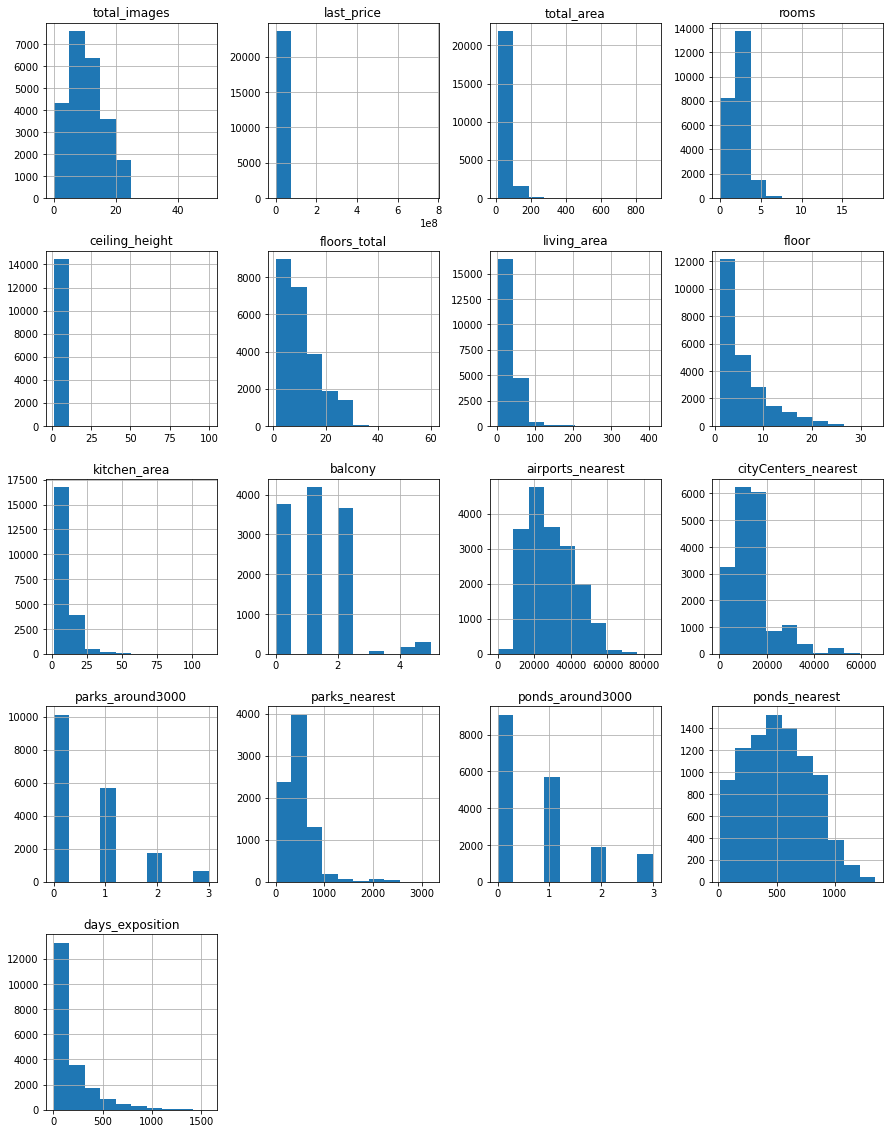

In [5]:
data.hist(figsize=(15,20))
plt.show()

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
Таблица состоит из 23699 записей, в части столбцов присутсвуют пропуски, так же стоит изменить тип некоторые типы данных.

## Предобработка данных

In [6]:
# пропущенные значения

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

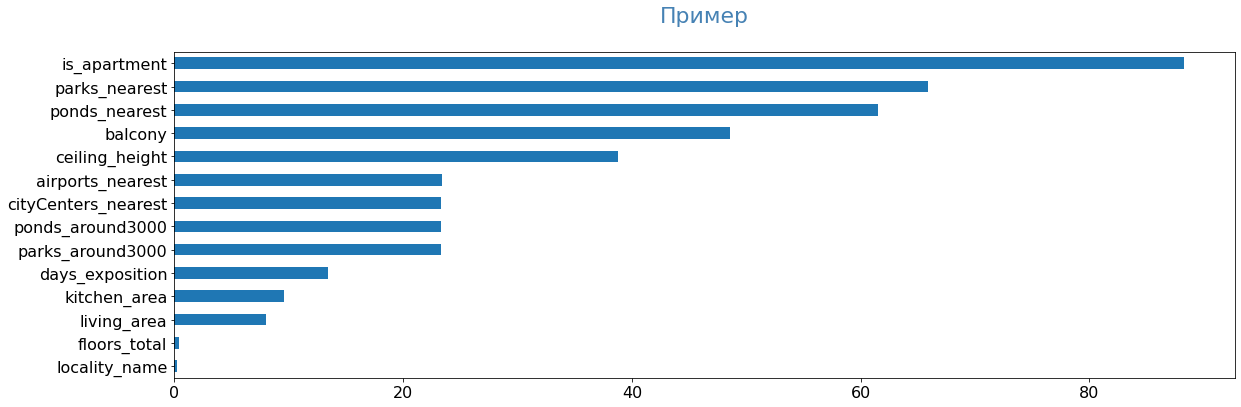

In [7]:
pass_value_barh(data)

###  Заполним пропуски:

Присутствуют пропуски в столбцах: 
- ceiling_height
- floors_total
- living_area
- is_apartment 
- kitchen_area
- balcony
- locality_name
- airports_nearest
- cityCenters_nearest
- parks_around3000
- parks_nearest
- ponds_around3000
- ponds_nearest
- days_exposition 

Скорее всего пропуски в столбце is_apartment обусловлены тем, что если продавец выставляет именно квартиру, то он просто не указывает, является это не является апартаментами, поэтому можно заполнить пропуски значениями False. 

In [8]:
data['is_apartment'].isna().sum() 

20924

In [9]:
data['is_apartment'] = data['is_apartment'].fillna(False) 

In [10]:
data['is_apartment'].isna().sum() # проверим заполнение

0

Пропуски в количестве балконов стоблце balcony скорее всего связаны с тем, что продавец не указал их, так как в квартире их нет, поэтому мы заменим их на ноль.

In [11]:
data['balcony'].isna().sum() 

11519

In [12]:
data['balcony'] = data['balcony'].fillna(0) 

In [13]:
data['balcony'].isna().sum() # проверим заполнение

0

Проверим пропуски в этажности домов, и, если их не много, удалим

In [14]:
data['floors_total'].isna().sum()

86

In [15]:
data = data[data['floors_total'].notna()]

In [16]:
data['floors_total'].isna().sum() # проверим заполнение

0

Вероятно продавцы просто не указывают высоту потолков, и так как это квартиры, то можно заменить эти пропуски медианным значением высоты потолков (чтобы не учитывать влияние выбросов).

In [17]:
data['ceiling_height'].isna().sum() 

9118

In [18]:
data['ceiling_height'].describe() # статистики для столбца с высотой потолков

count    14495.000000
mean         2.771495
std          1.261445
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />При заполнении средним или медианой необходимо четко отслеживать изменение других статистик: стандартное отклонение, дисперсию и другие параметры выборки
        
... если рассмотреть районность высоты потолков, т.к. в современных районах Питера высота потолков будет ожидаема ниже, чем в исторических, мы увидим, что заполнение подобного объема пропусков медианой или средним значением «размажет» это отличительное свойство объектов недвижимости в центре Питера
        
[Обработка пропусков в данных](https://loginom.ru/blog/missing)

In [19]:
data.loc[((data['locality_name']=='Санкт-Петербург') & (data['cityCenters_nearest']<=5000))] 
# выделим исторический центр Санкт-Петербурга 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
24,8,6500000.0,97.20,2015-10-31T00:00:00,2,NaN,3.0,46.5,1,False,...,19.60,0.0,Санкт-Петербург,20052.0,2336.0,3.0,411.0,3.0,124.0,265.0
35,6,15500000.0,149.00,2017-06-26T00:00:00,5,NaN,5.0,104.0,4,False,...,17.00,0.0,Санкт-Петербург,23670.0,3502.0,0.0,NaN,1.0,779.0,644.0
61,18,7990000.0,74.00,2017-08-24T00:00:00,2,NaN,4.0,43.0,4,False,...,20.00,0.0,Санкт-Петербург,22568.0,4288.0,1.0,363.0,0.0,NaN,609.0
63,2,20000000.0,118.00,2018-09-11T00:00:00,3,3.00,9.0,68.0,7,False,...,16.00,0.0,Санкт-Петербург,26055.0,4800.0,1.0,648.0,1.0,779.0,37.0
99,32,9600000.0,90.00,2017-09-26T00:00:00,4,NaN,5.0,67.0,2,False,...,8.00,0.0,Санкт-Петербург,23277.0,2818.0,0.0,NaN,0.0,NaN,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23644,7,4990000.0,62.50,2018-04-26T00:00:00,2,2.70,4.0,32.3,4,False,...,12.10,0.0,Санкт-Петербург,20141.0,4415.0,1.0,560.0,1.0,171.0,166.0
23648,14,10100000.0,78.00,2017-05-12T00:00:00,3,3.27,5.0,48.6,5,False,...,8.20,0.0,Санкт-Петербург,20933.0,1113.0,1.0,621.0,2.0,117.0,621.0
23665,11,4250000.0,47.00,2016-05-20T00:00:00,1,NaN,6.0,18.2,1,False,...,14.60,0.0,Санкт-Петербург,20503.0,4946.0,2.0,624.0,1.0,519.0,131.0
23691,11,9470000.0,72.90,2016-10-13T00:00:00,2,2.75,25.0,40.3,7,False,...,10.60,1.0,Санкт-Петербург,19424.0,4489.0,0.0,NaN,1.0,806.0,519.0


In [20]:
data.loc[((data['locality_name']=='Санкт-Петербург') & (data['cityCenters_nearest']<=5000))]['ceiling_height'].notna().sum()
# найдем среди этих записей не пустые значение в столбце с высотой потолков

1384

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Попробовать заполнить исторический центр своей медианной высотой потолков не получилось, а можно как-то по-другому учесть эту особенность?

In [21]:
# check
data.loc[(data['locality_name']=='Санкт-Петербург') & (data['cityCenters_nearest']<=5000) &\
     (data['ceiling_height'].notna()), 'ceiling_height'].median()

3.1

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
        
можно посмотреть на порядок применения loc

https://tonais.ru/library/zamena-odnogo-ili-neskolkih-znacheniy-v-stolbtse-v-dataframe?ysclid=l5jjs9blfj495302948
        
https://towardsdatascience.com/how-to-use-loc-and-iloc-for-selecting-data-in-pandas-bd09cb4c3d79
        
        
а затем на функцию transform()        

In [22]:
data['ceiling_height'] = data['ceiling_height'].fillna(2.65)


In [23]:
data['ceiling_height'].describe() 

count    23613.000000
mean         2.724581
std          0.990085
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

<font color='blue'> Среднее изменилось незначительно, стандартное отклонение уменьшилось, а медиана осталась без изменений (что ожидаемо, ведь пропуски заполнены именно ей).</font>

In [24]:
data[data['total_area'] <= data['living_area']+data['kitchen_area']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
184,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,False,...,6.20,0.0,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
220,8,3890000.0,37.00,2018-07-09T00:00:00,1,2.50,25.0,28.00,6,False,...,9.00,0.0,Санкт-Петербург,25408.0,16166.0,0.0,NaN,0.0,NaN,28.0
545,9,4700000.0,23.80,2018-12-28T00:00:00,1,2.65,18.0,20.00,9,False,...,5.00,0.0,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0
551,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,False,...,9.28,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0
601,12,5600000.0,53.70,2017-04-18T00:00:00,2,2.50,12.0,48.30,5,False,...,7.00,2.0,Санкт-Петербург,50477.0,13252.0,2.0,220.0,1.0,1250.0,167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22869,0,15000000.0,25.00,2018-07-25T00:00:00,1,100.00,5.0,14.00,5,True,...,11.00,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0
22963,16,3150000.0,102.00,2018-06-26T00:00:00,5,2.65,9.0,78.00,8,False,...,24.00,1.0,Кингисепп,NaN,NaN,NaN,NaN,NaN,NaN,57.0
23202,13,4919880.0,67.92,2018-10-23T00:00:00,2,2.65,3.0,63.00,3,False,...,13.04,0.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,60.0
23297,10,1850000.0,48.20,2019-03-13T00:00:00,2,2.65,5.0,42.20,2,False,...,6.00,1.0,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,45.0


<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
        
__Не стоит за счет комментариев увеличивать ширину строки__ 

<div class="alert alert-da nger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />После заполнения синтетическими данными столбцов, стоит провести проверку на корректность значений всех наших площадей, т.к. есть (коридоры, сан.узлы, балконы)
        
        total_area*0.9 <= (living_area + kitchen_area)
                                     
если алгоритм приводит к появлению аномалий, стоит подумать над его содержимым

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> При проверке до заполненеия данным выявились аномальные записи, подходящие под условие, а после заполнения их стало в три раза больше, поэтому я убрала заполнение.

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />принимается

Пропуски в столбце kitchen_area с площадью кухни и пропуски в столбце с жилой площадью living_area логично заполнить нечем.

In [25]:
data['locality_name'].isna().sum() # пропуски в названиях населенных пунктов

48

Заполнить логично эти пропуски не удастся, оставим как есть

- Пропуски в airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest связаны между собой, так как если, по какой-то причине, автоматически не удалось выяснить, где на карте находится объект, то и все эти расстояния определить тоже не получится. Либо же эти часть из них (airports_nearest, cityCenters_nearest, parks_around3000,ponds_around3000) определена, а пропуски в расстояниях до ближайшего парка/водоёма(parks_nearest, ponds_nearest) получились из-за отсутсвия их в радиусе 3 км.
- Так как у нас нет никаких идентификационных данных о каждом объявлении, выяснить, где конкретно находилась каждая квартира с пропусками мы не можем, логично заполнить расстояния мы тоже не можем. 

Проверим пропуски в столбце с количеством дней публикации объявления

In [26]:
data['days_exposition'].isna().sum() 

3172

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
        
В виде комментариев к коду стоит писать пояснения, почему ты применил те или иные методы python, зачем сгруппировал данные, для чего нужны срезы и т.д.
        
Все остальное — выводы, рекомендации, принятые решения, указание на обнаруженные аномалии, анализ графиков и т.д. нужно писать в ячейках markdown. Так твой проект будет проще читать.

Пожалуйста, воспользуйся методичкой по оформлению проектов, чтобы исправить эти недостатки. Ее можно найти в блоке курса: Полезные инструкции для учёбы - Оформление проекта - Рекомендации по выполнению проектов

In [27]:
data['days_exposition'].describe()

count    20441.000000
mean       180.884839
std        219.685543
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

- Разница в медианном значении (95 дней) и среднем (180 дней) существенная, есть что-то, что сильно сдвигает среднее в большую сторону. Заполнять пропуски средним или медианным значениями не будем. 
- Причина пропусков в этом столбце скорее всего связана с автоматической работой сервера, об этом стоит сообщить.

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
В таблице много пропусков, на это стоит обратить внимание. Возможно стоит при заполнении объявления некоторые поля обязательными для ввода, например жилую площадь, населенный пункт. Так же стоит выяснить откуда пропуски в автоматически заполняемых столбцах, например в днях размещения.
    

### Изменим тип данных где необходимо

В столбце first_day_exposition, указывающем дату публикации объявления, тип данных object заменим на datetime64. 

In [28]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
# переведим значения в столбце first_day_exposition в datetime

В столбце days_exposition округлим до целых

In [29]:
def to_round(value): # функция, которая отбросит дробную часть для упрощения поиска по конкретным целым числам (дням)
    try:
        return int(value)
    except:
        pass

In [30]:
data['days_exposition'] = data['days_exposition'].apply(to_round) 

Поменяем типа данных столбцов floors_total и balcony на int.

In [31]:
data['floors_total'] = data['floors_total'].astype('int')

In [32]:
data['balcony'] = data['balcony'].astype('int')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        23613 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
Тип данных нужно изменить для корректности работы с данными даты, например для получения информации по годам, месяцам или дням. Так же округление поможет в точном поиске по количеству дней. Изменять тип данных на нужный важно для корректной работы с данными таблицы.
    

### Изучим и устраним дубликаты

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Проверка на поиск дубликатов выполнена, молодец
        
Особенно это станет важным, когда мы перейдем к более сложным задачам на втором модуле курса
          
__Оптимальнее поиск дубликатов выполнять после обработки неявных дубликатов__

Неявные дубликаты могут скрываться в названиях населенных пунктов, посмотрим уникальные значения в этом столбце

In [34]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Cоздадим список из видов населенных пунктов чтобы удалить их из строк столбца locality_name, таким образом избавляясь от дубликатов.

In [35]:
list_name = ['посёлок городского типа', 'поселок городского типа', 'садовое товарищество', 'городской поселок',\
             'городской посёлок', 'садоводческое некоммерческое товарищество',\
             'поселок при железнодорожной станции', 'посёлок при железнодорожной станции', \
             'поселок станции', 'посёлок станции', 'коттеджный посёлок', 'коттеджный поселок',\
             'поселок', 'посёлок', 'деревня', 'село']

Перебирая виды населенных пунктов из списка, при их нахождении, удаляем их, и перезаписываем в столбец locality_name

In [36]:
for delete_location in list_name:
    data['locality_name'] = data['locality_name'].str.replace(f'{delete_location} ', '')

In [37]:
data['locality_name'].unique() # проверяем, все ли удалилось 

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [38]:
data.duplicated().sum() # проверим, нет ли повторяющихся полностью строк

0

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
Для дальнейшего избегания таких неявных дубликатов в названиях населенных пунктов стоит сделать поле, которое при вводе названия будет предлагать вариант населенного пункта и его названия.

In [39]:
# check
data.locality_name.nunique()

305

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Хорошая работа по избавлению от неявных дубликатов
        
 
        
Можно отметить в отчете — стоит ли объединять нас. пункты
        
        'деревня Кудрово' 
        'Кудрово'

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
        
+ дополнительно — на рабочих проектах стоит искать дубликаты по сумме ключевых параметров (подмножеству), для примера: 

 + общ. площадь квартиры,
 + этаж, 
 + общая этажность дома, 
 + расстояние до центра
 + название населенного пункта
 + кол-во комнат
    
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html?highlight=duplicat#pandas.DataFrame.duplicated
        
https://www.codecamp.ru/blog/pandas-find-duplicates/        

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Если нет полностью повторяяющихся строчек, то тогда эти дубликаты по сумме параметров стоит найти для того, чтобы удалить? Вот например эти?

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />на этом проекте тренируемся, навык пригодится уже на сборном проекте, про игры
        
хотя и здесь имеются подозрительные строчки — стоит добавить общую стоимость        

In [40]:
data[data.duplicated(subset=['total_area', 'floor', 'rooms', 'locality_name', 'cityCenters_nearest', 'last_price'], keep='first')]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2395,9,1750000.0,44.0,2016-06-09,1,2.65,5,18.0,1,False,...,14.0,0,Кириши,NaN,NaN,NaN,NaN,NaN,NaN,22.0
7458,7,2350000.0,32.0,2015-02-17,1,2.65,5,16.0,3,False,...,5.0,0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,751.0
8289,20,2150000.0,31.4,2017-08-22,1,2.50,4,18.7,2,False,...,5.0,0,Кузьмоловский,NaN,NaN,NaN,NaN,NaN,NaN,78.0
8705,8,3450000.0,40.0,2016-07-04,1,2.65,12,NaN,4,False,...,NaN,0,Санкт-Петербург,31552.0,12062.0,0.0,NaN,0.0,NaN,608.0
9886,1,2533531.0,42.5,2016-11-25,1,2.56,18,19.8,7,False,...,NaN,0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,549.0
13076,9,1200000.0,30.0,2017-12-15,1,2.60,4,24.0,4,False,...,6.0,0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,188.0
13627,11,26000000.0,130.0,2016-06-30,3,3.18,6,69.2,1,False,...,30.0,0,Санкт-Петербург,25201.0,6061.0,1.0,175.0,0.0,NaN,835.0
15553,0,1850000.0,32.0,2018-10-05,1,2.65,5,18.0,2,False,...,5.5,1,Отрадное,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16153,4,1748700.0,33.5,2016-09-08,1,2.56,18,16.7,2,False,...,7.8,0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,895.0
17994,12,4150000.0,45.0,2016-10-01,1,2.70,16,20.0,10,False,...,12.0,2,Санкт-Петербург,15331.0,14127.0,0.0,NaN,0.0,NaN,698.0


### Устранение редких и выбивающихся значений

In [41]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23613.000000,2.361300e+04,23613.000000,23613.000000,23613.000000,23613.000000,21743.000000,23613.000000,21382.000000,23613.000000,18081.000000,18104.000000,18105.000000,8045.000000,18105.000000,9061.000000,20441.000000
mean,9.874518,6.540555e+06,60.340678,2.071147,2.724581,10.673824,34.462781,5.877313,10.564128,0.593063,28788.008185,14185.084015,0.611433,490.554630,0.770119,518.209469,180.884839
std,5.681541,1.090172e+07,35.648988,1.078380,0.990085,6.597173,22.037433,4.873539,5.904316,0.960307,12626.209956,8614.132292,0.802168,341.336698,0.939075,277.887489,219.685543
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18575.000000,9233.750000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13093.000000,0.000000,455.000000,1.000000,503.000000,95.000000
75%,14.000000,6.799000e+06,69.800000,3.000000,2.700000,16.000000,42.300000,8.000000,12.000000,1.000000,37242.000000,16287.000000,1.000000,612.000000,1.000000,730.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Проверим столбец с ценами last_price

In [42]:
data['last_price'].sort_values()

8793         12190.0
17456       430000.0
14911       430000.0
16274       440000.0
17676       450000.0
            ...     
15651    300000000.0
1436     330000000.0
14706    401300000.0
19540    420000000.0
12971    763000000.0
Name: last_price, Length: 23613, dtype: float64

In [43]:
data.query('last_price == last_price.min()') #найдем запись с минимальной ценой

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.0,109.0,2019-03-20,2,2.75,25,32.0,25,False,...,40.5,0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


In [44]:
data = data[data['last_price'] > 12190] 
# удалим строку с минимальным значением в 12000, так как вряд ли эта квартира была куплена

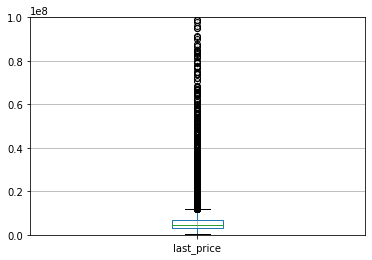

In [45]:
data.boxplot(column=['last_price']) #построим диаграмму размаха для цены
plt.ylim(0,100000000);


Выбросов много, но медиана стремиться к более низким значениям

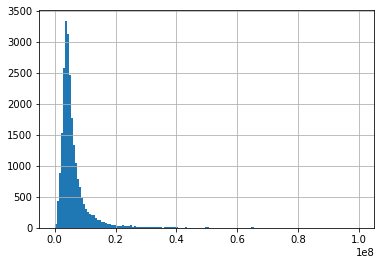

In [46]:
data['last_price'].hist(bins=150,range=(0,100000000));

In [47]:
data.query('last_price > 60_000_000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,NaN,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
155,8,96000000.0,317.0,2017-07-07,4,3.50,3,183.0,3,False,...,NaN,1,Санкт-Петербург,22673.0,1771.0,2.0,508.0,3.0,366.0,62.0
464,15,66571000.0,280.3,2015-06-11,6,5.20,8,159.5,7,False,...,21.1,0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
492,18,95000000.0,216.0,2017-12-05,4,3.00,5,86.0,4,False,...,77.0,0,Санкт-Петербург,21740.0,436.0,2.0,138.0,3.0,620.0,14.0
509,5,90000000.0,225.0,2016-06-26,6,2.65,4,134.0,2,False,...,19.5,2,Санкт-Петербург,32864.0,5720.0,0.0,NaN,2.0,519.0,416.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22494,7,91075000.0,491.0,2017-05-27,5,4.20,9,274.0,9,False,...,45.0,0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,115.0
22804,4,81960000.0,205.0,2017-09-29,4,3.20,9,108.0,3,False,...,10.0,0,Санкт-Петербург,21946.0,2242.0,1.0,679.0,1.0,227.0,169.0
22831,18,289238400.0,187.5,2019-03-19,2,3.37,6,63.7,6,False,...,30.2,0,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,NaN
22907,9,65000000.0,228.0,2016-06-02,4,2.65,5,200.0,2,False,...,NaN,0,Санкт-Петербург,22783.0,1295.0,3.0,619.0,3.0,269.0,NaN


Удалим эти записи, их не много, а стандартное отклонение станет на порядок меньше.

In [48]:
data = data[data['last_price'] < 60_000_000]

In [49]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23511.000000,2.351100e+04,23511.000000,23511.000000,23511.000000,23511.000000,21656.000000,23511.000000,21297.000000,23511.000000,17983.000000,18004.000000,18005.000000,7968.000000,18005.000000,8976.000000,20358.000000
mean,9.858832,6.059773e+06,59.411086,2.059844,2.722440,10.688146,33.985767,5.877717,10.461070,0.594190,28800.516043,14239.461453,0.605887,491.390437,0.764121,519.914884,180.273603
std,5.675391,5.274253e+06,31.593382,1.058734,0.990707,6.603086,20.126448,4.877188,5.503861,0.960672,12654.799114,8605.132296,0.796619,341.154712,0.934634,277.953814,219.196265
min,0.000000,4.300000e+05,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18539.000000,9327.500000,0.000000,288.000000,0.000000,296.000000,45.000000
50%,9.000000,4.600000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26758.000000,13138.000000,0.000000,456.000000,0.000000,504.000000,95.000000
75%,14.000000,6.700000e+06,69.100000,3.000000,2.700000,16.000000,42.100000,8.000000,12.000000,1.000000,37310.000000,16298.250000,1.000000,612.000000,1.000000,733.000000,231.000000
max,50.000000,5.991412e+07,517.000000,19.000000,100.000000,60.000000,332.000000,33.000000,100.700000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [50]:
data['rooms'].unique() # в уникальных значениях столбца с количеством комнат есть подозрительные значения больше 10

array([ 3,  1,  2,  4,  5,  6,  0, 11,  7,  8, 14, 10,  9, 19, 16])

In [51]:
data.query('rooms >10') #проверим квартиры с большим количеством комнат

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
648,3,17500000.0,183.7,2018-07-01,11,3.40,7,138.8,7,False,...,13.3,0,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN
866,5,25000000.0,363.0,2017-12-23,14,3.16,5,222.0,4,False,...,16.6,0,Санкт-Петербург,38076.0,7950.0,0.0,NaN,2.0,435.0,418.0
9688,8,33000000.0,194.1,2017-02-07,11,3.43,5,129.0,2,False,...,11.9,0,Санкт-Петербург,21469.0,1015.0,1.0,686.0,2.0,66.0,813.0
14498,6,32250000.0,374.6,2018-06-09,19,2.65,5,264.5,2,False,...,27.6,0,Санкт-Петербург,19497.0,3574.0,0.0,NaN,2.0,548.0,114.0
18848,6,28500000.0,270.0,2015-03-02,16,3.00,4,180.0,4,False,...,13.0,1,Санкт-Петербург,23575.0,4142.0,1.0,516.0,0.0,NaN,1365.0
20829,6,28659000.0,245.4,2016-03-31,14,2.65,4,168.3,2,False,...,25.9,0,Санкт-Петербург,21104.0,2054.0,3.0,541.0,2.0,118.0,95.0


Большие по площадям квартиры имеют много комнат, ничего криминального.

In [52]:
data['ceiling_height'].unique() #просмотрим уникальные значения столбца с высотой потолков

array([  2.7 ,   2.65,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   3.2 ,   2.61,   3.25,
         3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.3 ,   2.71,
         4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,   3.4 ,   3.5 ,
         3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,   2.58,
         3.7 ,   2.52,   2.87,   2.66,   2.59,   2.  ,   2.45,   3.6 ,
         2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,   3.16,   3.62,
         3.12,   2.53,   2.74,   2.96,   2.46,   5.  ,   2.79,   2.95,
         4.06,   2.94,   3.54,   3.53,   2.83,   2.4 ,   3.38,   3.01,
         5.6 ,   3.65,   3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,
         2.82,   3.98,   2.63,   3.83,   3.52,   3.95,   3.75,   2.88,
         3.67,   3.87,   3.66,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,
         4.2 ,   3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,
         8.  ,   3.26,   3.34,   2.81,   3.44,   2.97,   3.14,   4.37,
      

Есть выбивающиеся неправдоподобные значения высоты потолков, скорее всего опечатки при заполнении пользователями.

In [53]:
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height']<=10, data['ceiling_height']/10)
#перезапишем значения высоты, если оно больше 10м включительно, на значение, уменьшенное в 10 раз

In [54]:
data['ceiling_height'].unique() # проверим отсутсвие выбивающихся значений

array([ 2.7 ,  2.65,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  3.2 ,  2.61,  3.25,  3.45,  2.77,
        2.85,  2.64,  2.57,  4.15,  3.3 ,  2.71,  4.  ,  2.47,  2.73,
        2.84,  3.1 ,  2.34,  3.4 ,  3.5 ,  3.06,  2.72,  2.54,  2.51,
        2.78,  2.76,  2.58,  3.7 ,  2.52,  2.87,  2.66,  2.59,  2.  ,
        2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,  3.15,  3.55,  3.16,
        3.62,  3.12,  2.53,  2.74,  2.96,  2.46,  5.  ,  2.79,  2.95,
        4.06,  2.94,  3.54,  3.53,  2.83,  2.4 ,  3.38,  3.01,  5.6 ,
        3.65,  3.18,  3.35,  2.3 ,  3.57,  2.48,  2.62,  2.82,  3.98,
        2.63,  3.83,  3.52,  3.95,  3.75,  2.88,  3.67,  3.87,  3.66,
        3.86,  4.19,  3.24,  4.8 ,  4.5 ,  4.2 ,  3.36,  3.08,  3.68,
        3.07,  3.37,  3.09,  8.  ,  3.26,  3.34,  2.81,  3.44,  2.97,
        3.14,  4.37,  2.68,  3.9 ,  3.22,  3.27,  4.1 ,  2.93,  3.46,
        3.47,  3.33,  3.63,  3.32,  1.2 ,  8.3 ,  2.98,  2.86,  3.17,
        4.4 ,  3.28,

In [55]:
data['floors_total'].unique() #уникальные значения общей этажности жилого здания

array([16, 11,  5, 14, 12, 26, 24, 27,  9,  6, 17, 25,  3, 23, 19, 18,  4,
       22,  8,  2, 10,  7, 13, 15, 20, 28, 36, 21, 35, 34, 60,  1, 29, 33,
       52, 37])

In [56]:
data.query('floors_total > 37') #посмотрим записи с подозрительными значениями высотности здания

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60,27.4,4,False,...,7.4,0,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0
16731,9,3978000.0,40.0,2018-09-24,1,2.65,52,10.5,18,False,...,14.0,0,Санкт-Петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0


Самое высокое жилое здание в Санкт-Петербурге имеет 37 этажей, больше этого - скорее всего ошибка при заполнении. Удалим эти записи.

In [57]:
data = data[data['floors_total'] != 60] #удалим записи с этажностью больше 37 этажей
data = data[data['floors_total'] != 52] 

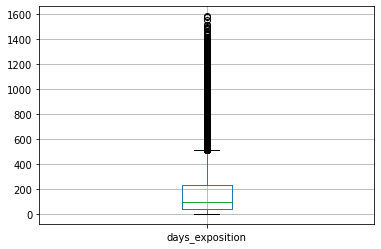

In [58]:
data.boxplot(column=['days_exposition']); # посмотрим диаграмму размаха для количества дней размещения объявления

Среднее значение для этого столбца - 180 дней, в то время как медианное - 95, подозрительно?

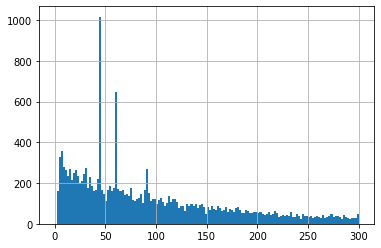

In [59]:
data['days_exposition'].hist(bins=150, range=(0,300)); #рассмотрим поближе гистограмму по количеству дней публикации

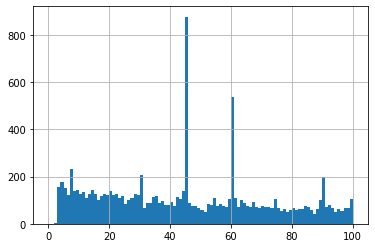

In [60]:
data['days_exposition'].hist(bins=100, range=(0,100));  #рассмотрим еще ближе

Виден пик около 45 и 60 дней. Стоит просмотреть срезы по этим дням.

In [61]:
data.query('days_exposition == 45') # срез данных по количеству дней публикации равном 45

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
78,9,4350000.0,37.0,2018-02-22,1,2.65,19,18.0,6,False,...,10.7,0,Санкт-Петербург,34324.0,14192.0,0.0,NaN,0.0,NaN,45.0
89,9,2500000.0,63.0,2018-10-25,3,2.50,5,43.0,4,False,...,9.0,0,Сиверский,NaN,NaN,NaN,NaN,NaN,NaN,45.0
110,6,3850000.0,72.3,2017-09-29,2,2.65,3,27.4,2,False,...,23.6,0,Пикколово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
153,12,4350000.0,55.0,2017-05-21,2,2.57,9,31.2,2,False,...,8.3,0,Петергоф,45958.0,34425.0,1.0,589.0,0.0,NaN,45.0
158,15,3100000.0,47.3,2017-11-07,2,2.65,5,27.5,2,False,...,8.5,0,Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23601,10,2900000.0,43.4,2018-01-11,2,2.65,5,NaN,1,False,...,NaN,0,Санкт-Петербург,22001.0,14193.0,1.0,202.0,2.0,397.0,45.0
23613,4,3950000.0,52.0,2018-03-04,3,2.65,5,NaN,2,False,...,NaN,0,Парголово,55549.0,21223.0,0.0,NaN,0.0,NaN,45.0
23670,9,2450000.0,45.6,2018-02-08,1,2.80,9,NaN,2,False,...,NaN,0,Синявино,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23679,0,2500000.0,35.0,2017-12-08,1,2.65,9,NaN,4,False,...,NaN,0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0


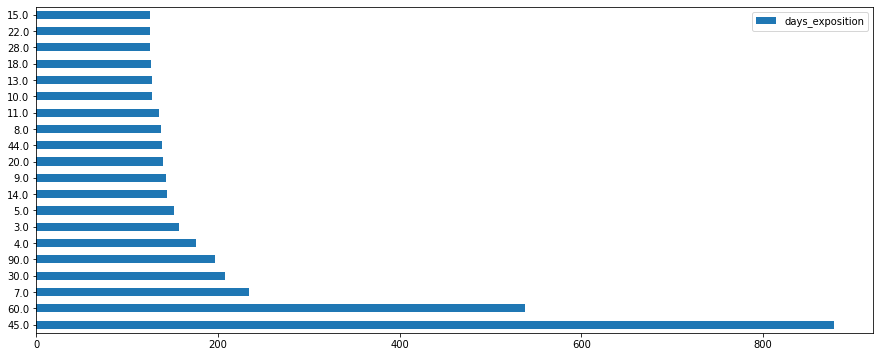

In [62]:
# check
# Моды на реальных данных
    
data['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

Не совсем понятно, в чем причина этого большого количества квартир со сроком публикации в 45 дней и в 60. Возможно, так работает автоматическая система, скрывая объявления без активности. 

<div class="alert alert-da nger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Моды на реальных данных
        
        Мода (Mo) представляет собой значение изучаемого признака, повторяющееся с наибольшей частотой, т.е. мода – значение признака, встречающееся чаще всего. Медианой (Me) называется значение признака, приходящееся на середину ранжированной (упорядоченной) совокупности, т.е. медиана – центральное значение вариационного ряда.
        

В нашем проекте — моды, из-за подозрения что это техническое снятие с продаж, могут искажать реальный расчет скорости продажи квартиры
        
полностью из проекта удалять их не стоит, можно временно исключить из расчета скорости продаж

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Стоит обратить внимание на формат числа, по этой причине не сработала фильтрация
        
        data['days_exposition'] != 45
        
хотя часть данных мы отфильтровали, возможно у нас в выборке записи с двумя форматами чисел
        
        45 и 45.0

In [63]:
data_without45_60_days = data.loc[((data['days_exposition']!=45) & (data['days_exposition']!=60))] 

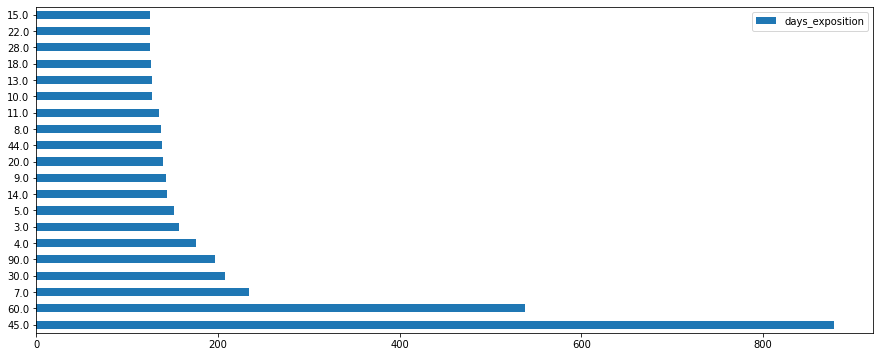

In [64]:
# check
# Моды на реальных данных
    
data['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

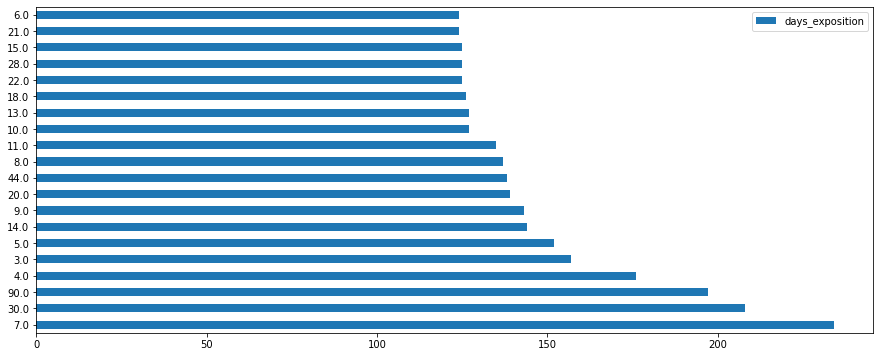

In [65]:
# моды на данных, в которых исключены 45 и 60 дни
data_without45_60_days['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">

- выбросы в сторону больших цен скорее всего оправданы, ведь это недвижимость и мы не знаем, как например оснащена эта квартира и какой там ремонт, поэтому стоит скорее не отбрасывать данные с большой ценой, а рассматривать квартиры по разным ценовым промежуткам;
- поле с вводом высоты потолков стоит ограничить высотой до 10 метров;
- так же возможно стоит ограничить выбор этажности дома;
- причину выбросов, связанных с 45 и 60 днями публикаций, определить не удалось, возможно стоит получить какие-то дополнительные данные;
- при исключении этих записей выяснилось, что чаще всего квартиры продают на 7, 30 и 90 дни

#### check gap

In [66]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23509 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23509 non-null  int64         
 1   last_price            23509 non-null  float64       
 2   total_area            23509 non-null  float64       
 3   first_day_exposition  23509 non-null  datetime64[ns]
 4   rooms                 23509 non-null  int64         
 5   ceiling_height        23509 non-null  float64       
 6   floors_total          23509 non-null  int64         
 7   living_area           21654 non-null  float64       
 8   floor                 23509 non-null  int64         
 9   is_apartment          23509 non-null  bool          
 10  studio                23509 non-null  bool          
 11  open_plan             23509 non-null  bool          
 12  kitchen_area          21295 non-null  float64       
 13  balcony         

<div class="alert alert-da nger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
стоит сменить тип данных в 
        
         6   floors_total          23065 non-null  float64       

пропуски можно удалить, кол-во их минимально        
        
         13  balcony               23151 non-null  float64           
        

         

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />

__проверим какие аномалии остались__ таблица ниже

In [67]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max', 'mean','median'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,509.00","23,509.00","23,509.00","20,356.00","23,509.00","21,654.00","21,295.00","23,509.00","23,509.00"
min,0.00,12.00,1.00,1.00,"430,000.00",2.00,1.30,1.00,1.00
max,19.00,517.00,10.00,"1,580.00","59,914,124.00",332.00,100.70,33.00,37.00
mean,2.06,59.41,2.70,180.28,"6,059,957.35",33.99,10.46,5.88,10.68
median,2.00,52.00,2.65,95.00,"4,600,000.00",30.00,9.10,4.00,9.00


<div class="alert alert-da nger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />остались аномалии и редкости (в т.ч. и хвосты) в колонках: 
        
        'rooms', 'total_area', 'ceiling_height', 'days_exposition',   'living_area',  'kitchen_area' 
        
стоит обратить внимание на минимальные и максимальные значения в выборке и учесть наличие пропусков при фильтрации данных
        


<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Доп. задание, на твое усмотрение — сможешь добавить в таблицу расчет медианного значения?
        
        (
            data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
                  'floor', 'floors_total']]
            .apply (['count', 'min', 'max'])   
            .style.format("{:,.2f}")
        )

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />принимается, табличка стала твоей собственостью :)

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Для выполнения пункта 2.4. существует два подхода
        
Можно механически бороться с выбросами, ...
               
основная проблема такого подхода — не учитывается неоднородность нашей выборки: у нас здесь и малые поселки, и вторая столица страны, и исторический фонд и массовая застройка, и однушки и довольно большое кол-во многокомнатных квартир, или наоборот одна две квартиры с количеством комнат больше 7-ми ...
        

        
если бы у нас в таблице были бы только однокомнатные квартиры из определенного района массовой застройки, тогда да, мы бы боролись с выбросами традиционными способами, при нашем многообразии населенных пунктов, многокомнатности такие подходы не работают... т.е. они работают, но это усложнит наш проект — придется разбить и объединить записи нашей таблицы по нескольким параметрам (кол-во комнат, район, и т.д.), а затем только выполнять все остальные пункты на каждой отдельной выборке
        
Остается другой подход — убираем редкие значения и следим за количеством потерь... 
         
Для выборки из 23-х тысяч значений, несколько записей со стоимостью квадратного метра выше 1-го млн. руб., довольно редкое явление

Хороший пример, высота потолков, которую мы отрезаем по нижней и верхней планке, это скорее аномальные записи, посмотрим на другой аспект — на редкости: кол-во комнат

__т.е. мы не говорим о том, что квартир с кол-ом комнат выше 7 не бывает, мы говорим, что для нашего исследования это редкие выбивающиеся из общей картины уникальные объекты, по которым необходимо проводить отдельную работу ...__
        
подобным образом рассматриваем и остальные параметры
        
наши помощники
        
1. гистограммы, с хорошим масштабом
2. метод describe() или облегченная версия, пример выше
3. метод value_counts()
        
плюс жизненный опыт 

In [68]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Эту таблицу создали для того, чтобы на ней проверить параметры фильтрации?

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />нет, чтобы показать примеры каким образом искать редкости и аномалии на сырых данных
        
фильтровать стоит основную выборку

In [69]:
# check
df_check.rooms.value_counts().to_frame().head()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326


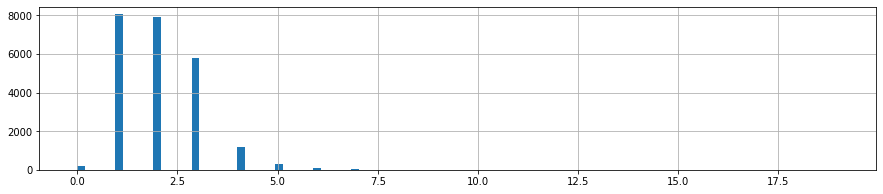

In [70]:
df_check.rooms.hist(bins=100, figsize = (15,3));

In [71]:
df_check.query('rooms > 5')['rooms'].count()

195

In [72]:
df_check = df_check.loc[((df_check['rooms'] <=5) | (df_check['rooms'].isna()))] 

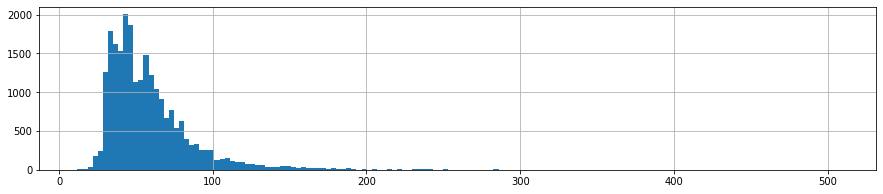

In [73]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />т.е. все квартиры менее 20-ти и более 250-ти квадратных метров можно считать редкостями
       

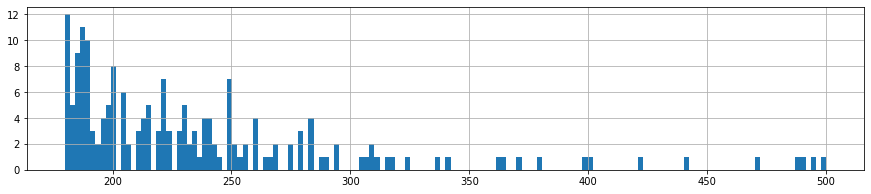

In [74]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

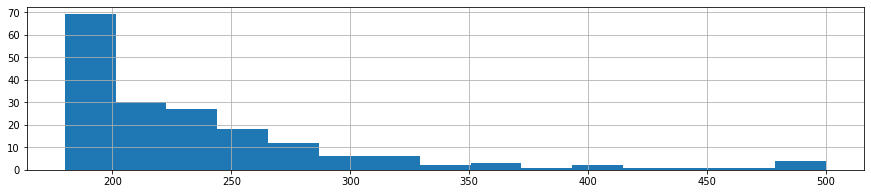

In [75]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

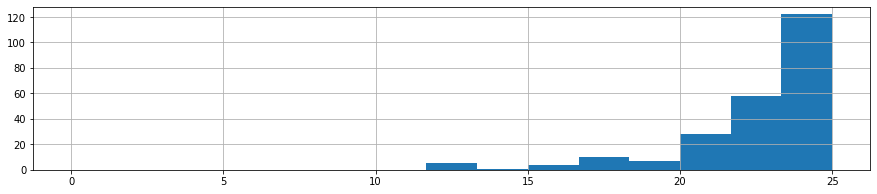

In [76]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [77]:
df_check.query('(total_area < 20) | (total_area > 250)')['total_area'].count()

79

In [78]:
df_check = df_check.loc[((df_check['total_area'] >=20 ) | (df_check['total_area'].isna()))] 

In [79]:
df_check = df_check.loc[((df_check['total_area'] <=250 ) | (df_check['total_area'].isna()))] 

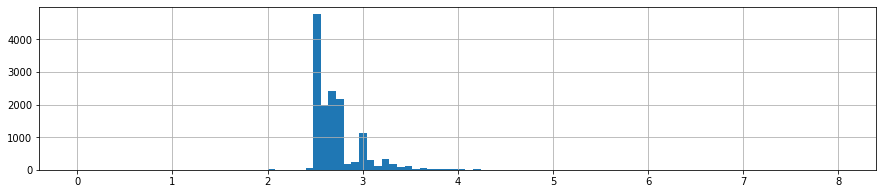

In [80]:
df_check.ceiling_height.hist(bins = 100, figsize = (15,3), range = (0,8));

In [81]:
df_check.query('(ceiling_height < 2) | (ceiling_height > 4)')['ceiling_height'].count()

67

In [82]:
df_check = df_check.loc[((df_check['ceiling_height'] >= 2 ) | (df_check['ceiling_height'].isna()))] 

In [83]:
df_check = df_check.loc[((df_check['ceiling_height'] <= 4 ) | (df_check['ceiling_height'].isna()))] 

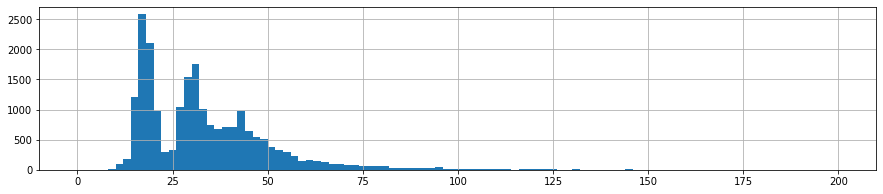

In [84]:
df_check.living_area.hist(bins = 100, figsize = (15,3), range=(0, 200));

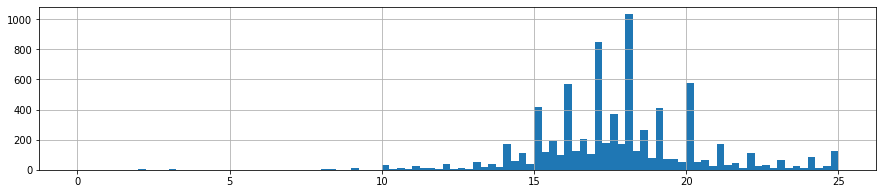

In [85]:
df_check.living_area.hist(bins = 100, figsize = (15,3), range=(0, 25));

In [86]:
df_check.query('(living_area < 10) | (living_area > 100)')['living_area'].count()

186

In [87]:
df_check = df_check.loc[((df_check['living_area'] >= 10 ) | (df_check['living_area'].isna()))] 

In [88]:
df_check = df_check.loc[((df_check['living_area'] <= 100 ) | (df_check['living_area'].isna()))] 

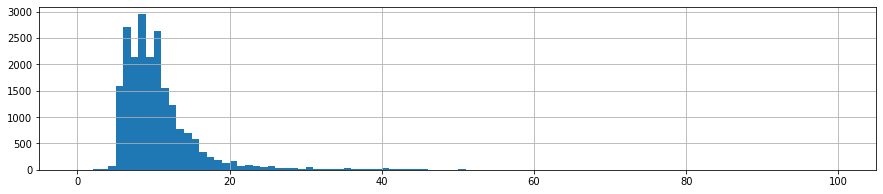

In [89]:
df_check.kitchen_area.hist(bins = 100, figsize = (15,3), range=(0, 100));

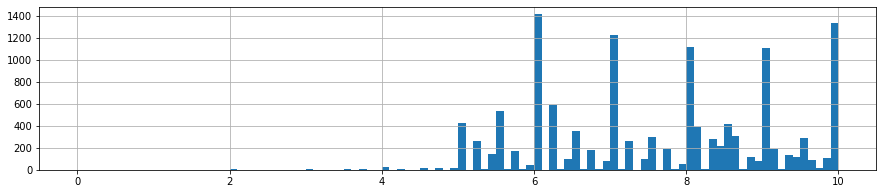

In [90]:
df_check.kitchen_area.hist(bins = 100, figsize = (15,3), range=(0, 10));

In [91]:
df_check.query('kitchen_area > 30')['kitchen_area'].count()

249

In [92]:
df_check = df_check.loc[((df_check['kitchen_area'] <=30) | (df_check['kitchen_area'].isna()))] 

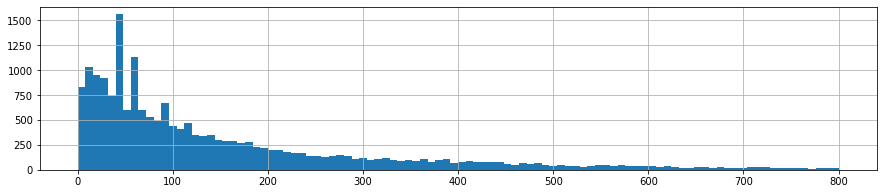

In [93]:
df_check.days_exposition.hist(bins = 100, figsize = (15,3), range=(0,800));

In [94]:
df_check.query('(days_exposition > 1000)')['days_exposition'].count()

252

In [95]:
df_check = df_check.loc[((df_check['days_exposition'] <=1000) | (df_check['days_exposition'].isna()))] 

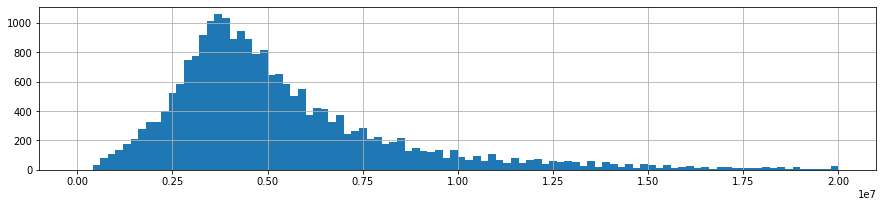

In [96]:
df_check.last_price.hist(bins = 100, figsize = (15,3), range=(0, 20_000_000));

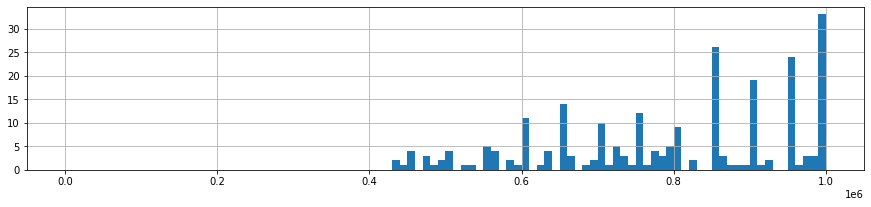

In [97]:
df_check.last_price.hist(bins = 100, figsize = (15,3), range=(0, 1_000_000));

In [98]:
df_check.query('(last_price < 400_000) | (last_price > 16_000_000)')['last_price'].count()

588

In [99]:
df_check = df_check.loc[((df_check['last_price'] >= 400_000 ) | (df_check['last_price'].isna()))] 

In [100]:
df_check = df_check.loc[((df_check['living_area'] <= 16_000_000 ) | (df_check['living_area'].isna()))] 

<div class="alert alert-dang er">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Осталось завершить выполнение пункта 2.4 из брифа проекта

2.4.	Найдите и устраните редкие и выбивающиеся значения.
        
__Критичный уровень потерь записей на этапе предобработки составляет 10%, оптимальный 5%__
        
Если при фильтрации одной колонки, на этом проекте, теряем больше одного процента данных от изначального объема, стоит еще раз пересмотреть условия фильтрации        

In [101]:
data = data.loc[((data['rooms'] <=5) | (data['rooms'].isna()))] 
data = data.loc[((data['total_area'] >=20 ) | (data['total_area'].isna()))] 
data = data.loc[((data['total_area'] <=250 ) | (data['total_area'].isna()))] 
data = data.loc[((data['ceiling_height'] >= 2 ) | (data['ceiling_height'].isna()))] 
data = data.loc[((data['ceiling_height'] <= 4 ) | (data['ceiling_height'].isna()))] 
data = data.loc[((data['living_area'] >= 10 ) | (data['living_area'].isna()))] 
data = data.loc[((data['living_area'] <= 100 ) | (data['living_area'].isna()))] 
data = data.loc[((data['kitchen_area'] <=30) | (data['kitchen_area'].isna()))] 
data = data.loc[((data['days_exposition'] <=1000) | (data['days_exposition'].isna()))] 
data = data.loc[((data['last_price'] >= 400_000 ) | (data['last_price'].isna()))] 
data = data.loc[((data['living_area'] <= 16_000_000 ) | (data['living_area'].isna()))] 

In [102]:
# check

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,593.00","22,593.00","22,593.00","19,611.00","22,593.00","20,804.00","20,447.00","22,593.00","22,593.00"
min,0.00,20.00,2.00,1.00,"430,000.00",10.00,1.30,1.00,1.00
max,5.00,240.00,4.00,"1,000.00","59,534,892.00",100.00,30.00,33.00,36.00


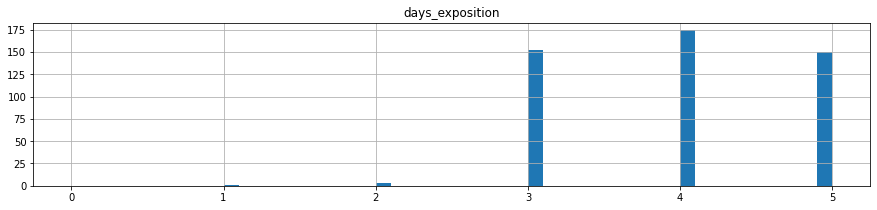

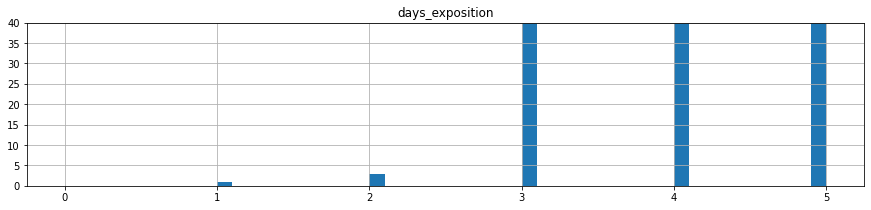

In [103]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Выполнен достойный объем работы, молодец
        
остались редкости в  скорости продаж: один или два дня и в площади кухни ...

In [104]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,21.71,2.40,3.00,"566,656.00",10.00,4.00,1.00,2.00
0.01,1.00,26.00,2.50,4.00,"1,000,000.00",13.27,5.00,1.00,2.00
0.5,2.00,51.00,2.65,92.00,"4,550,000.00",30.00,9.00,4.00,9.00
0.99,4.00,139.61,3.50,859.00,"23,300,000.00",83.19,25.00,23.00,26.00
0.9988,5.00,185.89,4.00,977.00,"43,857,054.40",98.00,30.00,26.00,33.89


<font color='blue'> Видно, что остались хвосты в общей площади и цене, но если их убрать, придется вырезать большее количество записей чем 1% от исходного количества на колонку.</font>

In [105]:
# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# урезанные данные
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max', 'mean', 'median'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,593.00","22,593.00","22,593.00","19,611.00","22,593.00","20,804.00","20,447.00","22,593.00","22,593.00"
min,0.00,20.00,2.00,1.00,"430,000.00",10.00,1.30,1.00,1.00
max,5.00,240.00,4.00,"1,000.00","59,534,892.00",100.00,30.00,33.00,36.00
mean,2.00,56.52,2.68,165.17,"5,627,412.02",32.29,9.93,5.90,10.75
median,2.00,51.00,2.65,92.00,"4,550,000.00",30.00,9.00,4.00,9.00


<font color='blue'>Видно, что медианные значения практически не изменились, максимальные практически везде стали меньше, средние значения стали ближе к медианным.</font>

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера </b></font>
    <br /> 
    <font size="3", color = "black">
<br />Квантили что это такое (первая ссылка иногда не открывается)
        
https://fin-accounting.ru/cfa/l1/quantitative/cfa-quartiles-quintiles-deciles-percentiles?ysclid=l7gy2kky4i156375632
        
https://www.codecamp.ru/blog/percentile-vs-quartile-vs-quantile/?ysclid=lg89wjm4zz267333250        
        
они помогают увидеть редкости и аномалии в данных

## Посчитайте и добавьте в таблицу новые столбцы

#### Столбец с ценой одного квадратного метра

Добавим столбец price_per_m2, содержащий цену одного квадратного метра для каждого объявления.

In [106]:
data['price_per_m2'] = data['last_price']/data['total_area'] 

#### Столбец с днем недели публикации объявления

Добавим столбец day_of_week, содержащий день недели публикации каждого объявления.

In [107]:
data['day_of_week'] = data['first_day_exposition'].dt.weekday

#### Столбец с месяцем публикации объявления

Добавим столбец publication_month, содержащий месяц публикации каждого объявления.

In [108]:
data['publication_month'] = pd.DatetimeIndex(data['first_day_exposition']).month

#### Столбец с годом публикации объявления

Добавим столбец publication_year, содержащий год публикации каждого объявления.

In [109]:
data['publication_year'] = pd.DatetimeIndex(data['first_day_exposition']).year

#### Столбец с типом этажа квартиры

Создадим временный столбец для функции, которая будет определять тип этажа по разности этажей, кроме первого, который определим сразу в этом столбце

In [110]:
data['temp_floor_type'] = (data['floors_total'] - data['floor']).where(data['floor']!=1, 'первый')

In [111]:
def determinant_floor_type(floor): # функция, возвращающая тип этажа
    if floor == 'первый':
        return 'первый'
    elif 0 <= floor < 1:
        return 'последний'
    elif floor < 0:
        return 'ошибка'
    return 'другой'

# если в floors_total пропуск, то этаж будет определяться как 'другой'

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />принимается

Применяем функцию determinant_floor_type к временному столбцу temp_floor_type для получения требуемого столбца с типом этажа квартиры floor_type

In [112]:
data['floor_type'] = data['temp_floor_type'].apply(determinant_floor_type) 

In [113]:
data = data.drop(columns = ['temp_floor_type'], axis = 1) # удаляем временный столбец temp_floor_type

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Функция хорошая, стоит учесть крайние условия: нулевые и отрицательные значения

Проверим, нет ли где то этажа квартиры выше, чем сам дом.

In [114]:
data.query('floor_type == "ошибка"') 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,day_of_week,publication_month,publication_year,floor_type


#### Столбец с расстоянием до центра города в километрах

Добавим столбец cityCenters_nearest_km, содержащий расстояние до центра, выраженное в километрах.

In [115]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest']/1000 

In [116]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].apply(to_round) 
# перезаписываем столбец с километрами целыми значениями, используя функцию, описанную выше в 2.2

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> данные добавлены корректно, молодец

Проверяем наличие всех новых столбцов в таблице

In [117]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,day_of_week,publication_month,publication_year,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,18.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,13.0
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,NaN,NaN,55.0,95065.789474,0,9,2018,другой,NaN
6,6,3700000.0,37.3,2017-11-02,1,2.65,26,10.6,6,False,...,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,другой,19.0


## Проведите исследовательский анализ данных

### Изучите следующие параметры объектов

#### Общая площадь

Построим гистограмму для общей площади всех квартир

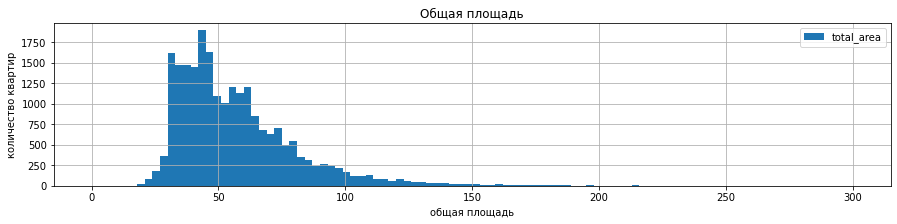

In [118]:
data.plot(y='total_area', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,300), title='Общая площадь')\
.set(xlabel='общая площадь', ylabel='количество квартир');

У гистограммы есть три пика, однако для общей площади квартир это нормально, много квартир построено по одинаковым планировкам и с одинаковыми площадями.

####  Жилая площадь

Гистограмма для жилой площади у всех квартир

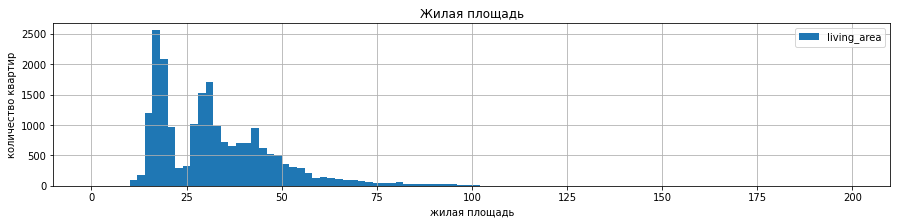

In [119]:
data.plot(y='living_area', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,200), title='Жилая площадь')\
.set(xlabel='жилая площадь', ylabel='количество квартир');

Опять же, три явных пика, что подтверждает то, что это три вида стандартных квартир (1, 2, и 3-х комнатные)

#### Площадь кухни

Гистограмма для площади кухни для всех квартир

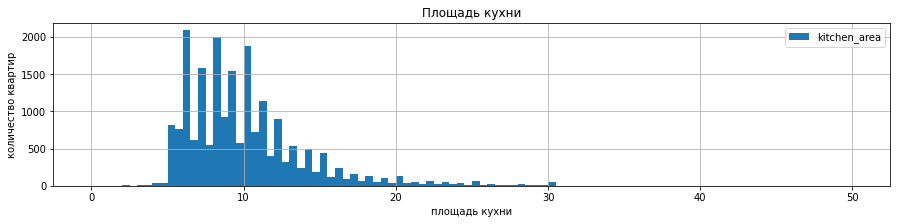

In [120]:
data.plot(y='kitchen_area', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,50), title='Площадь кухни')\
.set(xlabel='площадь кухни', ylabel='количество квартир');

У гистограммы есть пики около 5-15 метров квадратых, и плавный спад. Похоже на правду, кухни чаще всего бывают около 7-12 метров.

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Хорошие графики, можно добавить кол-во корзин к параметрам гистограммы и изменить размер у графиков (увеличить ширину)

Подписи осей на графиках и название добавят ясности и читабельности.
Это важные элементы любой визуализации. Как добавить подписи и названия, смотри [здесь](https://pyprog.pro/mpl/mpl_axis_signatures.html) и [там](https://pyprog.pro/mpl/mpl_title.html), и
        
[тут](https://proproprogs.ru/modules/matplotlib-razmeshchaem-standartnye-tekstovye-elementy-na-grafike?ysclid=l6agtioc6f299002507)

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
        
Первые две ссылки не открываются :С

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />дааа, что-то случилось, сорри, буду искать новые

#### Цена объекта

Построим гистограмму для последней указанной цены всех квартир

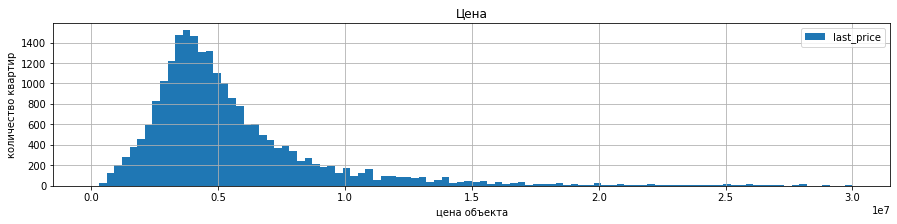

In [121]:
data.plot(y='last_price', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,30000000), title='Цена')\
.set(xlabel='цена объекта', ylabel='количество квартир');

Гистрограмма имеет плавный вид, немного растянута к большим значениям цены, для недвижимости это выглядит разумно.

#### Количество комнат

Гистограмма для количества комнат во всех квартирах

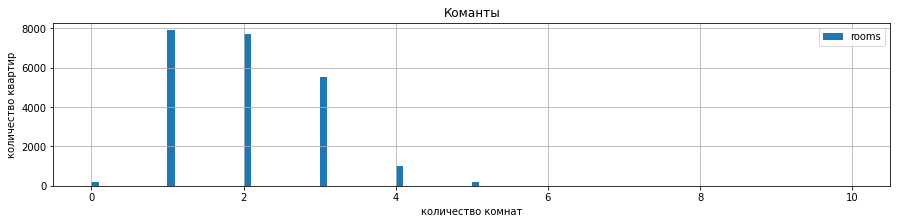

In [122]:
data.plot(y='rooms', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,10), title='Команты')\
.set(xlabel='количество комнат', ylabel='количество квартир');

Видно, что большинство квартир - однокомнатные и двухкомантные, также много трехкомнатных квартир. Гистограмма также подтверждает теорию о том, что три пика общей площади связаны с стандартными планировками квартир.

####  Высота потолков

Гистограмма для высоты потолков во всех квартирах

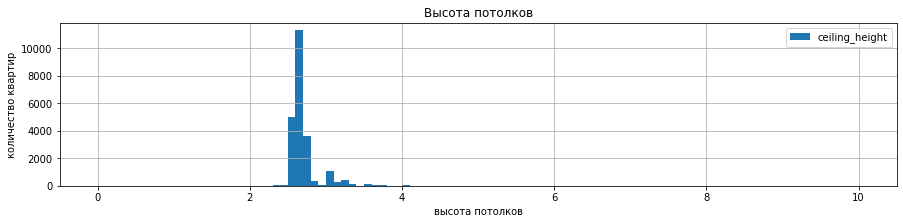

In [123]:
data.plot(y='ceiling_height', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,10), title='Высота потолков')\
.set(xlabel='высота потолков', ylabel='количество квартир');

В основном все квартиры имеют потолки около 2-4 метров, что соответствует действительности, высокий пик около среднего получился из-за заполнения медианным значением пропусков в столбце с высотой потолков.

#### Этаж квартиры

Гистограмма распредления всех квартир в объявлениях по этажам

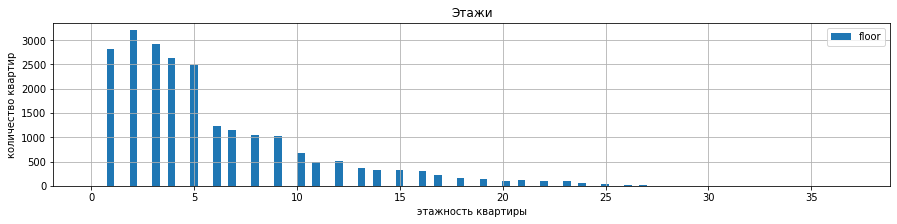

In [124]:
data.plot(y='floor', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,37), title='Этажи')\
.set(xlabel='этажность квартиры', ylabel='количество квартир');

По гистограмме видно, что большинство объявлений с квартирами, которые находятся от первого до пятого этажа, дальше происходит спад. Вероятнее всего это связанно с особенностями застройки, ведь в небольших городах не строят высокоэтажные дома, да и в целом строительство высоких домов началось гораздо позже, чем, например двухэтажных или пятиэтажных, выглядит правдоподобно.

#### Тип этажа квартиры («первый», «последний», «другой»)

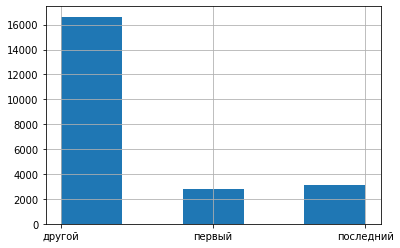

In [125]:
data['floor_type'].hist(bins=5);

Можно сказать, что есть небольшая разница в количестве квартир, находящихся на последнем этаже дома и на первом, в сторону последних этажей. Ожидаемо, что большинство квартир находятся на других этажах, учитывая разнообразие этажей.

#### Общее количество этажей в доме

Гистограмма распредления всех квартир в объявлениях по этажности домов, в которых они находятся

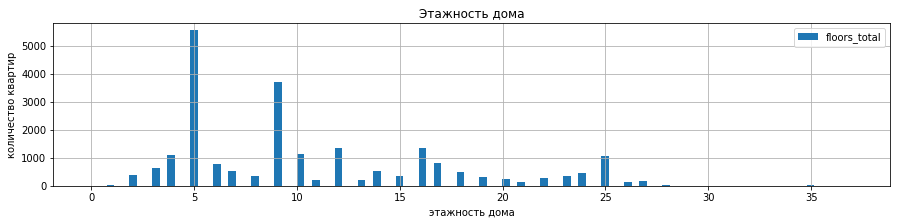

In [126]:
data.plot(y='floors_total', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,37), title='Этажность дома')\
.set(xlabel='этажность дома', ylabel='количество квартир');

Видно, что большинство это пятиэтажные дома, что сходится с пиком гистограммы по этажности самой квартиры. Так же видно что много девятиэтажных домов.

#### Расстояние до центра города в метрах

Распределение квартир по расстоянию от центра

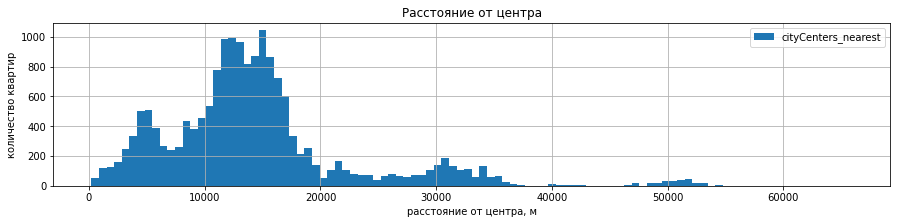

In [127]:
data.plot(y='cityCenters_nearest', kind='hist', bins=100, figsize = (15,3), grid=True, title='Расстояние от центра')\
.set(xlabel='расстояние от центра, м', ylabel='количество квартир');

Гистограмма не выглядит плавной, есть пик около 5000 м, высокий пик от 10000 м до 20000 м, и небольшой около 30000 м. Это расстояния до центра города, похоже, что большинство проданных квартир находятся на расстоянии около 15000 м от центра.

####  Расстояние до ближайшего аэропорта

Распределение квартир по расстоянию до аэропорта

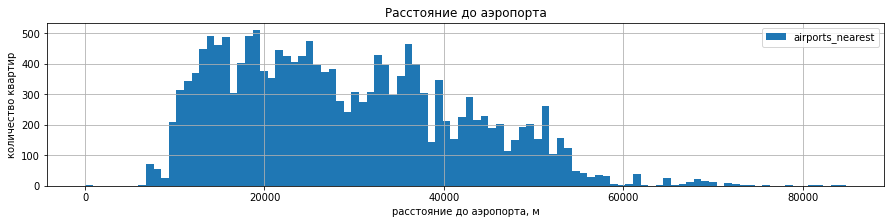

In [128]:
data.plot(y='airports_nearest', kind='hist', bins=100, figsize = (15,3), grid=True, title='Расстояние до аэропорта')\
.set(xlabel='расстояние до аэропорта, м', ylabel='количество квартир');

Тут распределение выглядит более плавно, квартиры располагаются более планомерно от аэропорта, большинство находятся на расстоянии от 20000 м до 40000 м от аэропорта

#### Расстояние до ближайшего парка

Распределение квартир по расстоянию до ближайшего парка

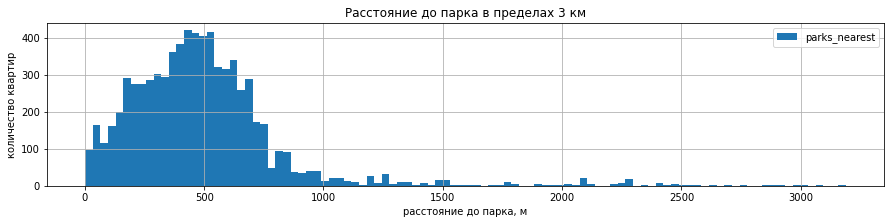

In [129]:
data.plot(y='parks_nearest', kind='hist', bins=100, figsize = (15,3), grid=True, title='Расстояние до парка в пределах 3 км')\
.set(xlabel='расстояние до парка, м', ylabel='количество квартир');

Исходя из квартир, рядом с которым есть парки, в основном они нахоядтся в пределах 1000 метрах.

#### День и месяц публикации объявления

Распределение объявлений по дню недели их публикации 

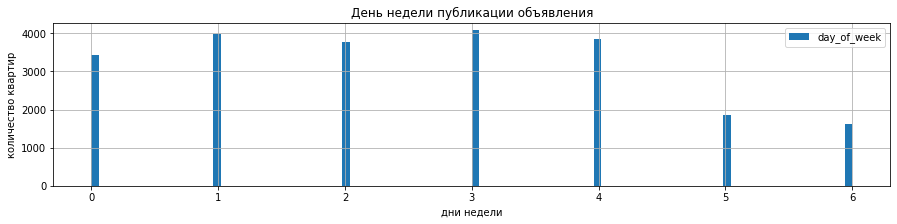

In [130]:
data.plot(y='day_of_week', kind='hist', bins=100, figsize = (15,3), grid=True, title='День недели публикации объявления')\
.set(xlabel='дни недели', ylabel='количество квартир');

На выходных реже всего выкладывают объявления, в будние дни примерно одинаковое количество.

Распределение объявлений по месяцам их публикации 

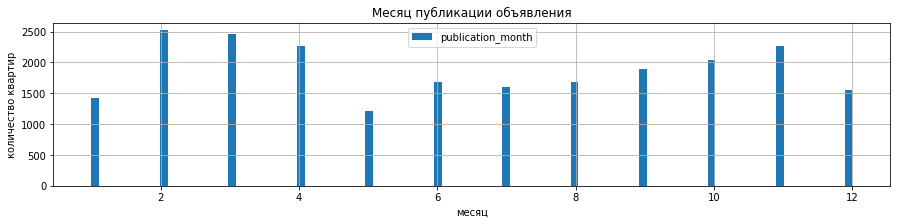

In [131]:
data.plot(y='publication_month', kind='hist', bins=100, figsize = (15,3), grid=True, title='Месяц публикации объявления')\
.set(xlabel='месяц', ylabel='количество квартир');

Чаще выкладывают объявления весной, летом происходит спад, и к зиме снова наблюдается рост, зимой же опять происходит спад.

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️  Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
        
__Интересно, почему февраль (самый короткий месяц) опережает все месяцы — ?__

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Все отошли от новогодних праздников и решили продавать имущество?

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Стоит смотреть на цифры и графики
        
Можно посмотреть на каждый февраль из нашей выборки, а затем на каждый день особого февраля ..., можно захватить  и предыдущий январь

<div style="border: solid pink 2px; padding: 20px">
Большинство квартир имеет стандартные площади, соответствующие трем видам стандартных квартир (1, 2, и 3-х комнатные). Кухни чаще всего бывают около 7-12 метров. Гистрограмма цен имеет плавный вид, немного растянута к большим значениям цены. В основном все квартиры имеют потолки около 2-4 метров. Большинство квартир находятся от первого до пятого этажа и, в основном, квартиры находятся не на первом или последних этажах. Больше всего домов - пятиэтажные, также много девятиэтажных домов. Большинство проданных квартир находятся на расстоянии около 15000 м от центра города, на расстоянии от 20000 м до 40000 м от аэропорта, и, если в пределах 3-х километров есть парк, то он находится не дальше 1000 метров. Чаще объявления выкладывают в будние дни весной и осенью.

### Изучите, как быстро продавались квартиры

Распределение объявлений по количеству дней, прошедших с момента публикации, до их снятия

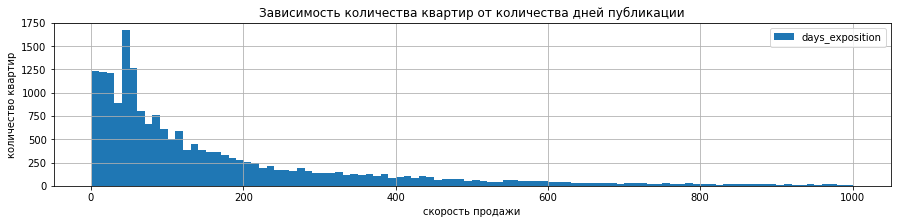

In [132]:
data.plot(y='days_exposition', kind='hist', bins=100, figsize = (15,3), grid=True, title='Зависимость количества квартир от количества дней публикации')\
.set(xlabel='скорость продажи', ylabel='количество квартир');

Посмотрим среднее, медиану и процентили для дней публикации

In [133]:
data['days_exposition'].describe(percentiles=[.25, .5, .75, .99]) 

count    19611.000000
mean       165.173729
std        185.771232
min          1.000000
25%         44.000000
50%         92.000000
75%        217.000000
99%        859.000000
max       1000.000000
Name: days_exposition, dtype: float64

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />

        
__Интересно посмотреть на изменение средней  скорости продаж по годам__

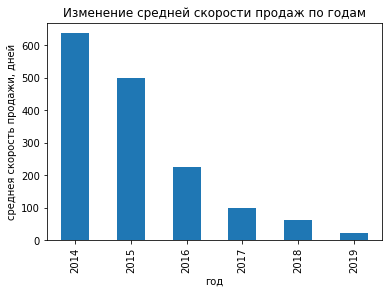

In [134]:
data.groupby('publication_year')['days_exposition'].median().plot(kind='bar', title='Изменение средней скорости продаж по годам')\
.set(xlabel='год', ylabel='среднея скорость продажи, дней');

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Только использовать с осторожностью, у нас еще больше 3000 непроданных квартир, которых нет в статистике о средней скорости продаж

<div style="border: solid pink 2px; padding: 20px">
    
- Будем считать быстрыми продажами те, у которых количество дней публикации меньше первого квартиля, то есть меньше 44 дней, а долгими те, у которых количество дней публикации больше третьего квартиля, то есть 217 дней. Необычно долгими можно считать те, у которых количество дней публикации больше 0,99-квартиля, то есть 859 дней.
    
- Скорость продаж увеличивается с каждым последующим годом, если в 2014 квартиру продавали в среднем за 600 дней, то в 2019 продают быстрее чем за 100 дней.

### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

#### Общая площадь

In [135]:
data['last_price'].corr(data['total_area']) # коэффициент корреляции зависимости между ценой и общей площадью

0.7387854070524721

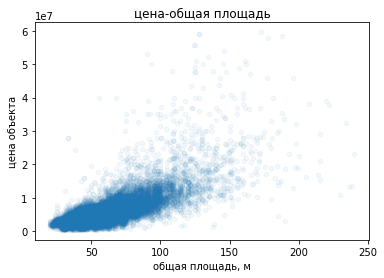

In [136]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.05, title='цена-общая площадь')\
.set(xlabel='общая площадь, м', ylabel='цена объекта'); # диаграмма рассеяния 

По диаграмме рассеяния видно, что это прямая зависимость цены от площади. Коэффициент корреляции достаточно большой, что показвает сильную связь между ценой и общей площадью.

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
<br /> 
<font size="3", color = "black">
<br />  Можно попробовать настроить вид точечных графиков      
    
[5.2. Scatter - график разброса (точки)](https://pyprog.pro/mpl/mpl_scatter.html?ysclid=l65k3vmmqd649359421)
    
Примеры расчета коэф. корреляции и не только
        
[Исследуем отношение между переменными](https://dfedorov.spb.ru/pandas/downey/%D0%98%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D1%83%D0%B5%D0%BC%20%D0%BE%D1%82%D0%BD%D0%BE%D1%88%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%BC%D0%B5%D0%B6%D0%B4%D1%83%20%D0%BF%D0%B5%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%BC%D0%B8.html?ysclid=l9ev0utyg728177057)

#### Жилая площадь

In [137]:
data['last_price'].corr(data['living_area']) 

0.6264745378784738

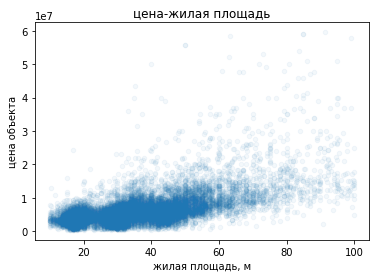

In [138]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.05, title='цена-жилая площадь')\
.set(xlabel='жилая площадь, м', ylabel='цена объекта'); # диаграмма рассеяния 

Опять же, диаграмма рассеяния очень похожа на предыдущую, здесь видна прямая зависимость, но коэффициент корреляции чуть меньше, чем в зависимости "общая площадь-цена".

#### Площадь кухни

In [139]:
data['last_price'].corr(data['kitchen_area']) 

0.5306875385784734

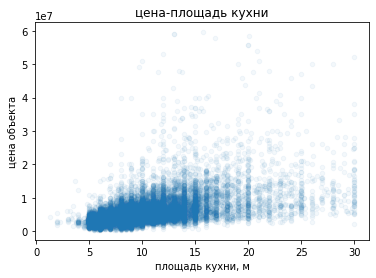

In [140]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.05, title='цена-площадь кухни')\
.set(xlabel='площадь кухни, м', ylabel='цена объекта');

Здесь же видно, что зависимость есть, но более слабая за счет того, что не смотря на большую или меньшую площадь кухни, по цене квартиры с такими кухнями могут стоить очень разных денег.

#### Количество комнат 

Столбчатая диаграмма, показывающая зависимость медианной стоимости квартиры по комнатам

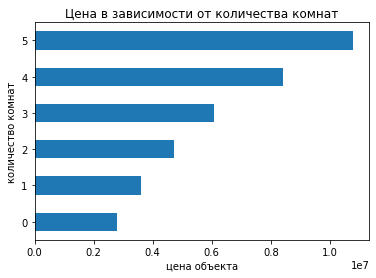

In [141]:
data.groupby('rooms')['last_price'].median().plot(kind='barh', title='Цена в зависимости от количества комнат')\
.set(xlabel='цена объекта', ylabel='количество комнат'); 

Видно, что с увеличением количества комнат происходит увеличение медианной стоимости квартиры, что согласуется с тем, что чем больше площадь квартиры, тем она стоит больше.

#### Этаж, на котором расположена квартира (первый, последний, другой)

Столбчатая диаграмма, показывающая зависимость медианной стоимости квартиры от типа этажа

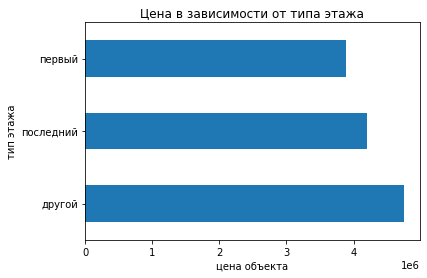

In [142]:
data.groupby('floor_type')['last_price'].median().sort_values(ascending=False)\
.plot(kind='barh', title='Цена в зависимости от типа этажа')\
.set(xlabel='цена объекта', ylabel='тип этажа'); 

По графику видно, что в целом все квартиры на "первом" этаже обошлись более дешево, чем на "последнем", но "последние", в свою очередь, обошлись дешевле, чем на "другом".

#### Дата размещения (день недели, месяц, год)

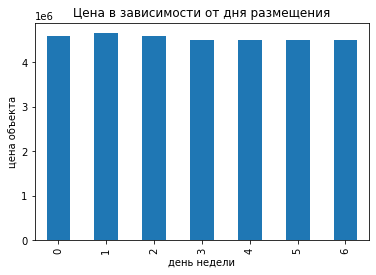

In [143]:
data.groupby('day_of_week')['last_price'].median().plot(kind='bar', title='Цена в зависимости от дня размещения')\
.set(xlabel='день недели', ylabel='цена объекта');
# столбчатая диаграмма, показывающая зависимость медианной стоимости квартиры от дня недели, в который была выложена публикация

В не зависимости от дня недели, в который было выложено объявление, цена в объявлении от этого практически не меняется.

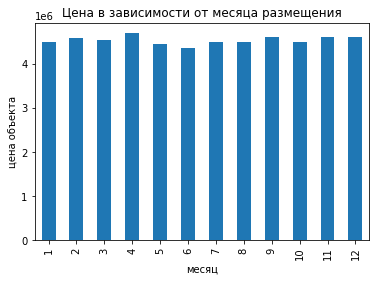

In [144]:
data.groupby('publication_month')['last_price'].median().plot(kind='bar', title='Цена в зависимости от месяца размещения')\
.set(xlabel='месяц', ylabel='цена объекта');
# столбчатая диаграмма, показывающая зависимость медианной стоимости квартиры от месяца, в который была выложена публикация

С месяцами в целом такая же ситуация, как и с днями недели, есть незначительные колебания, но в целом диаграмма ровная.

Столбчатая диаграмма, показывающая зависимость количества объявлений от года, в который они были выложены

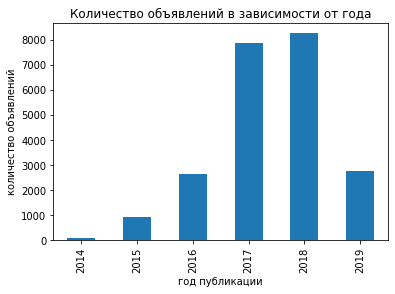

In [145]:
data.groupby('publication_year')['last_price'].count().plot(kind='bar', title='Количество объявлений в зависимости от года')\
.set(xlabel='год публикации', ylabel='количество объявлений');


Столбчатая диаграмма, показывающая зависимость медианной стоимости квартиры от года, в который была выложена публикация

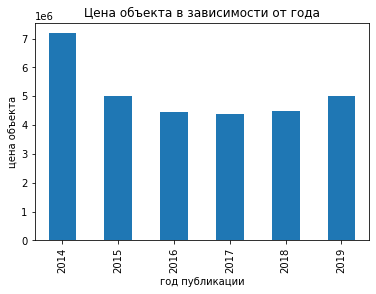

In [146]:
data.groupby('publication_year')['last_price'].median().plot(kind='bar', title='Цена объекта в зависимости от года')\
.set(xlabel='год публикации', ylabel='цена объекта');

Несмотря на то, что пик публикаций приходится на 2017-2018 года, в 2014 квартиры или стоили сильно дороже, либо их было не очень много, но достаточно дорогих.

<div class="alert alert-dan ger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Стоит дополнить  вывод об изменении цен по годам, необходимо учесть другие факторы, которые также изменяются с годами: площадь и кол-во объявлений о продаже (стоит добавить или графики, или сводные таблицы и исследовать взаимное влияние параметров: кол-во записей и изменение средней цены и средней площади в течение лет)
        
        два графика из трех у тебя уже имеются

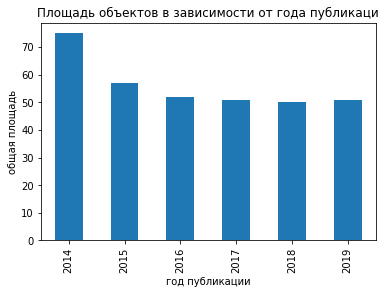

In [147]:
data.groupby('publication_year')['total_area'].median().plot(kind='bar', title='Площадь объектов в зависимости от года публикаци')\
.set(xlabel='год публикации', ylabel='общая площадь');

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">

Из всех факторов, влияние общей площади на стоимость квартиры кажется самым сильным, влияние жилой площади и площади кухни тоже является закономерным. Стоимость квартир растет с ростом количества комнат, что так же косвенно связанно с увеличением общей площади. Первый этаж немного "удешивляет" квартиру. Дата и месяц размещения объявления не влияет на стоимость квартиры. Пик публикаций объявлений приходится на 2017-2018 года, самые дорогие квартиры и большие по площади квартиры продавались в 2014 году.

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
        
Если смотреть только на изменение цены по годам мы можем сделать некорректный вывод, что цены падали, а на самом деле цена это параметр на который влияет несколько других факторов, по этой причине можно посмотреть на основные из них: 
        
+ изменение кол-ва записей — принять решение о достаточности данных для анализа и сравнения (сравнивать 100 объявлений и 8000, а возможно, что они еще и из разных локаций, не совсем корректно) 
+ изменение площади, как основного параметра от которого зависит стоимость квартиры, в 2017-2018 гг. на сервис или рынок ИТ-торговли недвижимостью пришел массовый продавец, и средние значения упали ..., а за ней и цена
+ изменение кол-ва поданных объявлений из разных локаций, т.к. есть питерские квартиры, а есть выборгские квартиры и стоят они по разному, и в разные годы могло быть больше квартир из определенной локации
+ полнота периода для анализа, 2014 и 2019 гг. неполные, а у нас есть сезонные колебания цен, например летнее снижение цен
+ изменение доли дорогих категорий в общей выборке (средние этажи)
 
и т.д.

### Средняя цена одного квадратного метра в 10 населённых пунктах

In [148]:
name_list = data.groupby('locality_name')['price_per_m2'].count().sort_values(ascending=False).head(10).index 
# сгруппируем данные по наименованию населенного пункта, 
# посчитаем записи для каждого из них, отсортируем по возрастанию и выведем топ-10 населенных пунктов по количеству объявлений

<div class="alert alert-dan ger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Не стоит создавать ручные переменные, стоит сразу передать список в переменную 
        
        name_list 

In [149]:
data[data['locality_name'].isin(name_list)]\
.pivot_table(index='locality_name', values='price_per_m2', aggfunc='mean')\
.sort_values(by='price_per_m2', ascending=False).style.format("{:.2f}")
# выбираем записи с подходящими населенными пунктами
# из них создаем сводную таблицу со средней ценой за квадратный метр
# сортируем по убыванию

,price_per_m2
locality_name,
Санкт-Петербург,111340.69
Пушкин,102762.96
Кудрово,95311.60
Парголово,90259.74
Мурино,86120.19
Шушары,78543.28
Колпино,75279.71
Гатчина,68727.95
Всеволожск,68609.98


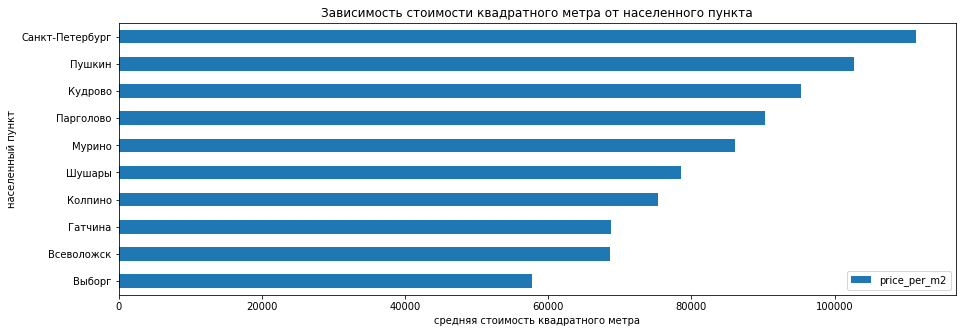

In [150]:
data[data['locality_name'].isin(name_list)]\
.pivot_table(index='locality_name', values='price_per_m2', aggfunc='mean')\
.sort_values(by='price_per_m2', ascending = True).plot(y='price_per_m2', kind='barh', figsize = (15,5), title='Зависимость стоимости квадратного метра от населенного пункта')\
.set(xlabel='средняя стоимость квадратного метра', ylabel='населенный пункт');

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
Самый дорогой квадратный метр из десяти населенных пунктов по количеству объявлений приходится на Санкт-Петербург (112775 за квадратный метр), самый недорого - на Выборг (58405 за квадратный метр).

<div class="alert alert-dan ger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Недостаточно найти числа, стоит их показать красиво, удобно и наглядно, чтобы одного взгляда хватило, где самые самые, а где подешевле 📊

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
<br /> 
<font size="3", color = "black">
<br />         
    
[Постер поможет выбирать вид графиков](https://www.notion.so/6c5ae8ceb8b5411e907c93c9b5e6a44e)

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> на проектах стоит снижать размерность выводимой информации, где не требуется максимальная точность, до одного или двух знаков после запятой
        
        Всеволожск	68790.240990
        Гатчина	68547.406313
        Выборг	58405.796358

### Опишите, как стоимость объектов зависит от расстояния до центра города.

In [151]:
data_St_Petersburg = data[data['locality_name'] == 'Санкт-Петербург'] 
# создадим таблицу, состаящую из объявлений о продаже в Санкт-Петербурге

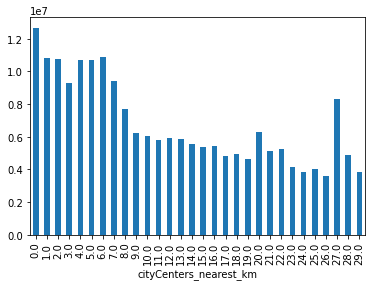

In [152]:
data_St_Petersburg.groupby('cityCenters_nearest_km')['last_price'].mean().plot(kind='bar');
# столбчатая диаграмма зависимости медианной цены от километра 

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Молодец, у тебя получилось сгруппировать и построить график изменения медианной цены в зависимости от расстояния до центра
        
по проекту ищем изменение средней цены

<div class="alert alert-d anger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />         
Стоит посмотреть на количество квартир разных категорий (первый, последний, другой), которые продаются на 3-м км. и 5-ом ... и какую долю они занимают на каждом километре, чтобы объяснить пик  и провал в центре

In [153]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==3]['floor_type'].value_counts(normalize=True)

другой       0.635347
последний    0.210291
первый       0.154362
Name: floor_type, dtype: float64

In [154]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==4]['floor_type'].value_counts(normalize=True)

другой       0.751316
последний    0.146053
первый       0.102632
Name: floor_type, dtype: float64

In [155]:
# check
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==5]['floor_type'].value_counts(normalize=True)

другой       0.748068
последний    0.143740
первый       0.108192
Name: floor_type, dtype: float64

<font color='blue'> Доля квартир на "другом" этаже выросла с переходом от третьего к четвертому километру от центра, а доля "последнего" и "первого" упала. Исходя из 4.3.5, где мы выяснили что квартиры на "другом" этаже дороже всего, а квартиры на "первом" дешевле, из-за роста доли квартир на "другом" этаже, средняя цена квартиры при переходе с третьего на четвертый километр выросла.</font> 

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Размер доли категорий квартир с более дешевой стоимостью намного больше на 3-м километре, чем на пятом, что является одной из причин падения и пика...
        
возможно к этому фактору добавляются и другие

In [156]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==8]['floor_type'].value_counts(normalize=True)

другой       0.781553
последний    0.126214
первый       0.092233
Name: floor_type, dtype: float64

In [157]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==9]['floor_type'].value_counts(normalize=True)

другой       0.756024
последний    0.153614
первый       0.090361
Name: floor_type, dtype: float64

<font color='blue'> При переходе с восьмого на девятый километр доля "последнего" и "первого" этажей выросла, а "другого" упала, что уменьшило среднюю стоимость квартиры</font> 

In [158]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==19]['floor_type'].value_counts(normalize=True)

другой       0.790123
последний    0.148148
первый       0.061728
Name: floor_type, dtype: float64

In [159]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==20]['floor_type'].value_counts(normalize=True)

другой       0.827160
последний    0.098765
первый       0.074074
Name: floor_type, dtype: float64

<font color='blue'> При переходе с девятнадцатого на двадцатый километр доля "последнего" и "первого" упала, а"другого" выросла, что повлекло увеличение средней стоимости квартиры. </font> 

In [160]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==27] # проверим пик около 27 км

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,day_of_week,publication_month,publication_year,floor_type,cityCenters_nearest_km
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,1496.0,0.0,NaN,128.0,193918.918919,1,11,2017,другой,27.0
5961,6,2250000.0,32.0,2018-02-27,1,2.65,2,16.5,2,False,...,NaN,0.0,NaN,178.0,70312.500000,1,2,2018,последний,27.0


По диаграмме видно, что самое дорогое жилье - очевидно - находится ближе всего к центру. Пики около 3-4, 8-9 и 19-20 километров объяснены изменением доли квартир с разными типами этажей. Пик около 27 км объясняется дорогой квартирой за 14 милионнов, это скорее исключение, чем правило.

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера </b></font>
    <br /> 
    <font size="3", color = "black">
<br />принимается, 
        
у нас всего 2 записи на 27-м км., одна из которых с аномальной ценой, по этой причине мы отвергаем данное наблюдение
        
__кол-во наблюдений важный параметр для оценки качества данных__

In [161]:
data_price_per_km = data_St_Petersburg.groupby('cityCenters_nearest_km')['price_per_m2'].median().\
to_frame(name='price_per_m2_median')
# создадим таблицу из медианной цены квадратного метра для каждого километра

In [162]:
data_price_per_km['diff'] = data_price_per_km['price_per_m2_median'].diff()
# добавим столбец diff с разностью между медианными ценами 

In [163]:
data_price_per_km.head()

,price_per_m2_median,diff
cityCenters_nearest_km,,
0.0,125565.610860,NaN
1.0,122448.979592,-3116.631268
2.0,116158.293042,-6290.686550
3.0,108892.921960,-7265.371082
4.0,125374.416026,16481.494066


In [164]:
data_price_per_km['diff'].mean() # среднее значение разности между ценами за квадратный метр 

-2365.1333335752415

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
В среднем с каждым километром от центра квадратный метр квартиры дешевеет на 2500.

## Общий вывод

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">

1. В таблице много пропусков, на это стоит обратить внимание. Возможно стоит при заполнении объявления некоторые поля обязательными для ввода, например жилую площадь, населенный пункт, высота потолков, этажность дома (возможно).

2. Причину выбросов, связанных с 45 и 60 днями публикаций, определить не удалось, возможно стоит получить какие-то дополнительные данные. При исключении этих записей выяснилось, что чаще всего квартиры продают на 7, 30 и 90 дни.

3. Большинство квартир имеет стандартные площади, соответствующие трем видам стандартных квартир (1, 2, и 3-х комнатные). Кухни чаще всего бывают около 7-12 метров. Гистрограмма цен имеет плавный вид, немного растянута к большим значениям цены. В основном все квартиры имеют потолки около 2-4 метров. Большинство квартир находятся от первого до пятого этажа и, в основном, квартиры находятся не на первом или последних этажах. Больше всего домов - пятиэтажные, также много девятиэтажных домов. Большинство проданных квартир находятся на расстоянии около 15000 м от центра города, на расстоянии от 20000 м до 40000 м от аэропорта, и, если в пределах 3-х километров есть парк, то он находится не дальше 1000 метров. Чаще объявления выкладывают в будние дни весной и осенью.

4. Срок быстрых продаж - меньше 44 дней, а долгих - больше 217 дней. Необычно долгих - больше 859 дней. Скорость продаж увеличивается с каждым последующим годом, если в 2014 квартиру продавали в среднем за 600 дней, то в 2019 продают быстрее чем за 100 дней.
    
5. Из всех факторов, влияние общей площади на стоимость квартиры кажется самым сильным. Дата и месяц размещения объявления не влияет на стоимость квартиры. Пик публикаций объявлений приходится на 2017-2018 года, самые дорогие квартиры и большие по площади квартиры продавались в 2014 году.
  
6. Самый дорогой квадратный метр из десяти населенных пунктов по количеству объявлений приходится на Санкт-Петербург (112775 за квадратный метр), самый недорого - на Выборг (58405 за квадратный метр). В среднем с каждым километром от центра квадратный метр квартиры дешевеет на 2500. По диаграмме видно, что самое дорогое жилье - очевидно - находится ближе всего к центру. Пики около 3-4, 8-9 и 19-20 километров объяснены изменением доли квартир с разными типами этажей. 

<div class="alert alert-da nger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Технически вывод хороший, есть сравнения показателей, инсайты, анализ рынка недвижимости, молодец
        
Осталось перепроверить итоговый вывод после исправления всех комментариев

<div class="alert alert-success">
<font size="5"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Выполнила исследовательскую работу, молодец, показала хороший уровень навыков программирования
        
Критические ❌ комментарии

+ вернуть пропуски в колонку о скорости продаж        
+ проверить корректность заполнения пропусков синтетическими данными        
+ сменить тип данных
+ настроить фильтрацию редких значений в п. 2.4
+ добавить вывод в п. 4.3
+ поправить переменную и добавить график в ТОП-10
+ исследовать аномалии в п.4.5
+ поправить итоговый вывод
        
        
С ними важно поработать и исправить
        
Стоит обратить внимание и на такие комментарии ⚠️
        
Если будут вопросы про мои комментарии - задавай, если какой-то формат взаимодействия не устраивает или есть какие-то другие пожелания - пиши :)

<div class="alert alert-success">
    <font size="5"><b>Жду твой проект и твои комментарии 🤝</b></font><br />
    
нумерация пунктов из брифа проекта, у тебя они могут быть другие

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
<br /> 
<font size="3", color = "black">
<br />    
    
[Обработка пропусков в данных](https://loginom.ru/blog/missing)
    
<p> Доп. материал: методы группировки и расчета суммы, средних и т.д.
        
[Подробное руководство по группировке и агрегированию с помощью pandas](https://dfedorov.spb.ru/pandas/%D0%9F%D0%BE%D0%B4%D1%80%D0%BE%D0%B1%D0%BD%D0%BE%D0%B5%20%D1%80%D1%83%D0%BA%D0%BE%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D0%BE%20%D0%B3%D1%80%D1%83%D0%BF%D0%BF%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B5%20%D0%B8%20%D0%B0%D0%B3%D1%80%D0%B5%D0%B3%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8E%20%D1%81%20%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E%20pandas.html)
    
 Интересная функция в библиотеке пандаса
        
[Понимание функции transform в Pandas](https://dfedorov.spb.ru/pandas/%D0%9F%D0%BE%D0%BD%D0%B8%D0%BC%D0%B0%D0%BD%D0%B8%D0%B5%20%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8%20transform%20%D0%B2%20Pandas.html)
    
[Как выбрать определенные столбцы из DataFrame](https://dfedorov.spb.ru/pandas/03.%20%D0%9A%D0%B0%D0%BA%20%D0%B2%D1%8B%D0%B1%D1%80%D0%B0%D1%82%D1%8C%20%D0%BF%D0%BE%D0%B4%D0%BC%D0%BD%D0%BE%D0%B6%D0%B5%D1%81%D1%82%D0%B2%D0%BE%20%D0%B8%D0%B7%20DataFrame_.html?ysclid=l9sps5lt6g576766938)
    
[How to visualise data using histograms in Pandas](https://practicaldatascience.co.uk/data-science/how-to-visualise-data-using-histograms-in-pandas)

## Бонус

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера в2</b></font>
<br /> 
<font size="3", color = "black">
<br />Диаграмма рассеяния

In [165]:
# check
import seaborn as sns
import matplotlib.pyplot as plt

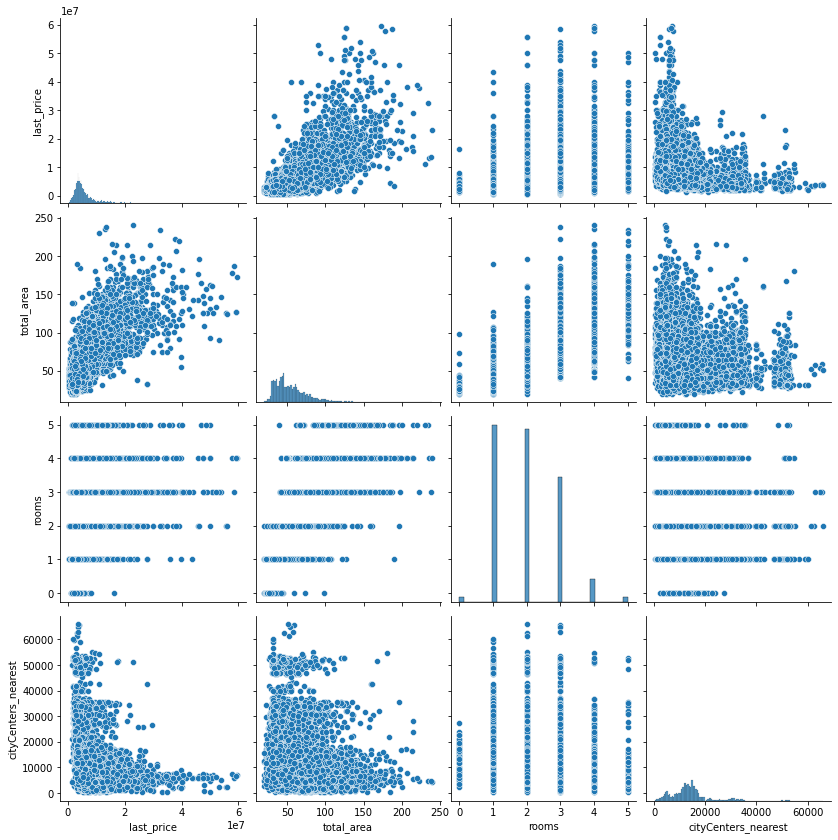

In [166]:
# check
sns.pairplot(data[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']])
plt.gcf().set_size_inches(12,12);


<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера в2</b></font>
<br /> 
<font size="3", color = "black">
<br />         
    
[5.2. Scatter - график разброса (точки)](https://pyprog.pro/mpl/mpl_scatter.html?ysclid=l65k3vmmqd649359421)

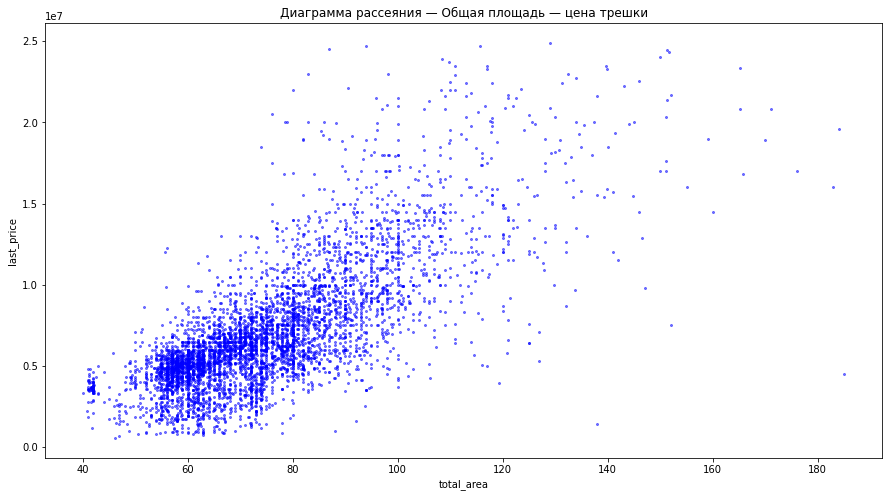

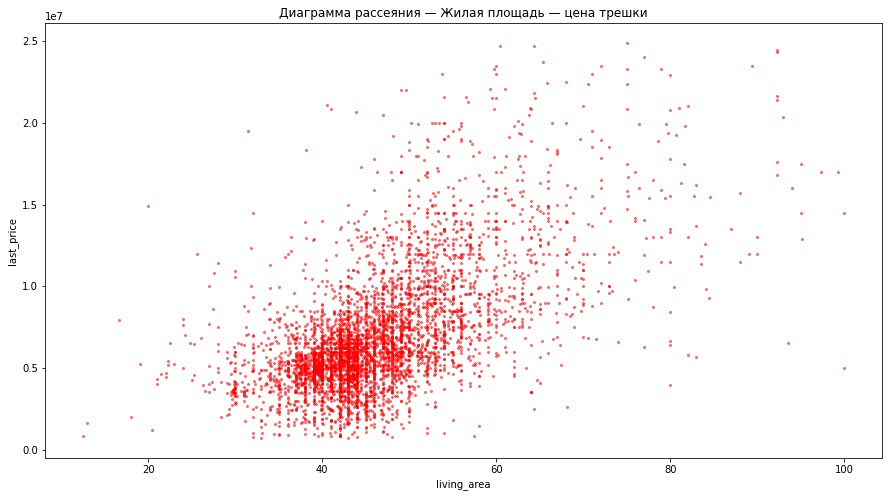

In [167]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');

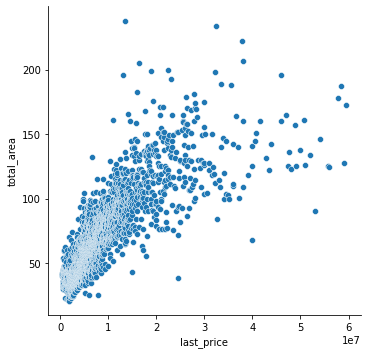

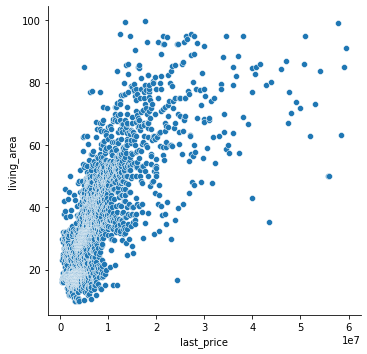

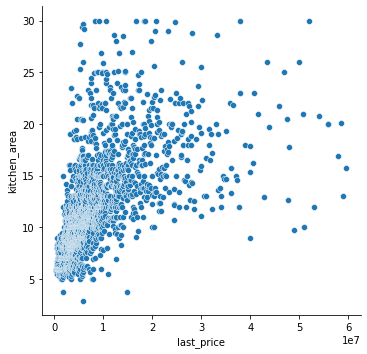

In [168]:
# check
price_pivot_area = data.pivot_table(index='last_price', values=([
    'total_area', 'living_area', 'kitchen_area']), aggfunc='median')
price_pivot_area = price_pivot_area.reset_index()
# Посмотрим на диаграммы рассеяния для столбцов 'total_area', 'living_area', 'kitchen_area'.
for row in ['total_area', 'living_area', 'kitchen_area']:
    sns.relplot(data=price_pivot_area, x='last_price', y=row, kind='scatter')

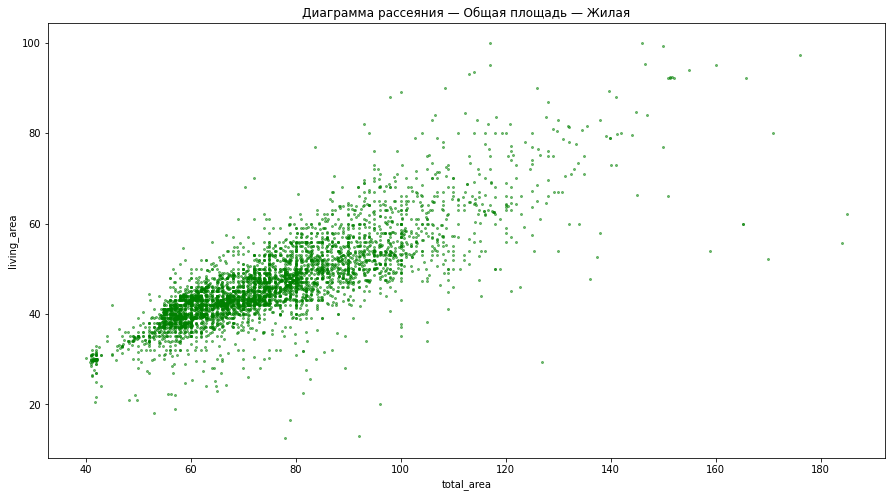

In [169]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'g', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');